# Klon Centaur, part 2
Last update: 26 July 2025  

In this notebook, LTSpice will be used to analyze the operation of the pedal using device models for the Op Amps and diodes. The Op Amp and diode device models describe the nonlinear operation of these devices and LTSpice is capable of performing nonlinear analysis, something that the Python MNA can't do.

The results from LTSpice are saved as a comma separated value (_csv_) file and imported into this notebook for plotting and comparison with the Python results. @fig-Klon-Centaur_v2_sch shows the schematic used in the LTSpice analysis. The circuit is a redrawn version of Martin Chittum’s Klon Centaur schematic shown in @fig-Chittum_Klon_sch except that the ICL7660 and its associated components have been replaced by fixed voltage sources, $V2$, $V3$, $V4$ and $V5$.

The motivating reason for employing LTSpice for this part of the analysis is to explore the effects of the non-linear components. The Diodes, $D_2$ and $D_3$, are the primary components that introduce distortion into the signal path. Under the combined conditions of moderate gain setting on $P_1$ and relatively large drive input, the Op Amp $U_{1B}$ can be driven into saturation. When this occurs the output tone will be a combination of non-linearities produced by the clipping of the signal by the Op Amp as the signal levels are driven beyond the power supply rails for $U_{1B}$ and the signal limiting resulting from the diodes.

Given the mystic and alleged magical ability of some types of Germanium diodes to produce superior musical sounds, it seems that Op Amp saturation should be avoided, otherwise the sound will be muddled and negating the point and argument for "special" Germanium diodes.

The analysis presented in this chapter will start with a description of the schematic in @fig-Chittum_Klon_sch. The Op Amps and Germanium diodes are discussed. Then LTSpice was used to do a parameter sweep where the input signal level was varied from 0.1 volts to 1.5 volts while the gain was varied from 1$\Omega$ to 99 k$\Omega$. The voltages at various points in the circuit were plotted versus these parameters. Next the circuit was examined with sinusoidal input signals of various amplitudes and the harmonic content of the diode limiting was examined. Actual musical signals were also used as input to the simulation since LTSpice has the ability to read _wav_ files. Finally a comparison of LTSpice results versious Python MNA circuit analysis results is presented to validate the Python MNA analysis.

The following Python modules are used in this notebook.

$\large{\color {red} {\text{Note for author:}}}$

What is the value of doing MNA of this circuit?  
pros and cons  

- if the operation is basically non linear why bother with MNA? Because we can get some insight into the frequency shaping paths, they could be equally analyzed in LTSpice. But analytic expressions for the reactive branches can be developed and with the expressions modifications to the design can be considered.


- Klon Centaur, part 2: Effects path non-linear analysis
- circuit description
- Op Amp and Diode description
- Pedal gain, Op Amp saturation and Diode saturation
- sine wave input
- actual signals
- Comparison of MNA and LTSpice results

ToDo

- work on FFT y-axis scaling and units.
  

In [50]:
from sympy import *
import numpy as np
from scipy import signal
#from scipy.signal import blackman
import scipy.fft
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()
from tabulate import tabulate

## Non-linear analysis with LTSpice {#sec-nonlinear_analysis}
The schematic shown below was drawn in LTSpice. The voltage converter, U3, in @fig-Chittum_Klon_sch, has been replaced by the voltage sources, $V2$, $V3$, $V4$ and $V5$. Voltage source, $V1$, is the guitar input signal. The effects bypass switch modeled by setting $R_{26}$ to 68k $\Omega$ and $R_{27}$ to 0.01 $\Omega$, which models switch S1A shorting $R_{27}$ to the wiper terminal of P3. All of the resistors and capacitors are assumed to be ideal. The schematic includes power supply connections for the Op Amps. In the analysis that follows, I'll be looking at conditions where the Op Amps might be driven into saturation. 

![Schematic of the Klon Centaur used for the LTSpice nonlinear analysis.](Klon-Centaur_v2.png){#fig-Klon-Centaur_v2_sch}

## Semiconductor components
Within the Klon Centaur's circuits there are several semiconductor devices used. These are the diodes, Op Amps and voltage converter. This section will describe these components and their use in the circuit.

### Dual High Slew Rate JFET Input Op Amp - TL072
The operational amplifier (Op Amp) used in the pedal is the [TL072](https://www.ti.com/product/TL072?bm-verify=AAQAAAAJ_____4l2d6J1dP-up0vwzV75bF018toeB6LvlnsE608z6iBbtlasxEASuWLQUYtzLESDjkX0dSsHD60J9zGYP0c54tzWogKch76Q4F0jkyRIy1M6yC_v9XfTRzpoIY_OO1AZMjCPP2TX-ZhA0f0IQH4K51wgft8CjuH6gbEF7DTNCQYFlJUKVsc0gvaEJpaTaAomByzKNyQf00fndw_mtFdOnFJ5NWqeafPGWHyOvVfL32vIDhFOZ5bHShMDSWaNUvjfcX4dZHJ6q5rSV19vIAJ8RrT9ZTdFzS-t6HtxLmXoF4DHwg), available from Texas Instruments.
The TL072 is a dual, high slew rate, JFET-input Op Amp and is part of a family of industry-standard devices (TL071, TL072, and TL074). There are next-generation versions available (TL071H, TL072H, and TL074H). The TL072 product continues to be available for existing customers, but new designs should consider an alternate product.

The TL072 provides outstanding value for cost-sensitive applications, and features include: low offset (1 mV, typical), high slew rate (20 V/µs), and common-mode input to the positive supply. High ESD (1.5 kV, HBM), integrated EMI and RF filters, and operation across the full –40°C to 125°C enable the TL07xH devices to be used in the most rugged and demanding applications. 

The TL072 is available from Digikey from two manufacturers, [Texas Instruments](https://www.digikey.com/en/products/filter/instrumentation-op-amps-buffer-amps/687?s=N4IgjCBcoLQdIDGUBmBDANgZwKYBoQB7KAbRACYBOANhAF0BfBg80kAFwwAYB2VxoA) and [STMicroelectronics](https://www.digikey.com/en/products/filter/instrumentation-op-amps-buffer-amps/687?s=N4IgjCBcoLQdIDGUBmBDANgZwKYBoQB7KAbRABYBOAdhAF0BfBggJlJABcMAGatxoA).

The in LTSpice circuit simulations that follow, the following [PSpice Model](https://www.ti.com/product/TL072?bm-verify=AAQAAAAJ_____-lTe0JulZ9CqD5uoWAVyNnjsrL88hHq1vTru3T9CqLbfuaSyDLIOOpld10D0GSD9kvMmc1SIOS_B4yZl2__HuJmwsX4W7hXggYazZRQuYuQegllzmDro9t5E_gCIMIqZrGSbZvjrU33jzkVcyOEV0FzFtD9sW-WcIaexAXWykgbLqWmO-3IkAqOuFuHutaWX_SEf0gOZASn23dYYQitU4qrudYAGx_Lj3xIBKe7Jb-z4oKmxI5M7riaPhBJ3hTxnAj-S72-AY7OeTxKtwmZ3IwkjE0BOG__IEnDF6BUVrNJIw#design-development) model from Texas Instruments was used: 

```
* TL072 OPERATIONAL AMPLIFIER "MACROMODEL" SUBCIRCUIT
* CREATED USING PARTS RELEASE 4.01 ON 06/16/89 AT 13:08
* (REV N/A)      SUPPLY VOLTAGE: +/-15V
* CONNECTIONS:   NON-INVERTING INPUT
*                | INVERTING INPUT
*                | | POSITIVE POWER SUPPLY
*                | | | NEGATIVE POWER SUPPLY
*                | | | | OUTPUT
*                | | | | |
.SUBCKT TL072    1 2 3 4 5
*
  C1   11 12 3.498E-12
  C2    6  7 15.00E-12
  DC    5 53 DX
  DE   54  5 DX
  DLP  90 91 DX
  DLN  92 90 DX
  DP    4  3 DX
  EGND 99  0 POLY(2) (3,0) (4,0) 0 .5 .5
  FB    7 99 POLY(5) VB VC VE VLP VLN 0 4.715E6 -5E6 5E6 5E6 -5E6
  GA    6  0 11 12 282.8E-6
  GCM   0  6 10 99 8.942E-9
  ISS   3 10 DC 195.0E-6
  HLIM 90  0 VLIM 1K
  J1   11  2 10 JX
  J2   12  1 10 JX
  R2    6  9 100.0E3
  RD1   4 11 3.536E3
  RD2   4 12 3.536E3
  RO1   8  5 150
  RO2   7 99 150
  RP    3  4 2.143E3
  RSS  10 99 1.026E6
  VB    9  0 DC 0
  VC    3 53 DC 2.200
  VE   54  4 DC 2.200
  VLIM  7  8 DC 0
  VLP  91  0 DC 25
  VLN   0 92 DC 25
.MODEL DX D(IS=800.0E-18)
.MODEL JX PJF(IS=15.00E-12 BETA=270.1E-6 VTO=-1)
.ENDS
```

The following informative references are recommended:

- [Op amps in small-signal audio design – Part 1: Op amp history, properties](https://www.eetimes.com/op-amps-in-small-signal-audio-design-part-1-op-amp-history-properties/)
- [Op amps in small-signal audio design – Part 2: Distortion in bipolar and JFET input op-amps](https://www.eetimes.com/Op-amps-in-small-signal-audio-design---Part-2--Distortion-in-bipolar-and-JFET-input-op-amps/?Ecosystem=audio-design/)
- [Op amps in small-signal audio design – Part 3: Selecting the right op amp](https://www.eetimes.com/op-amps-in-small-signal-audio-design-part-3-selecting-the-right-op-amp/)


### General Purpose Germanium Diode - 1N34A
The clipping diodes, $D_2$ and $D_3$, are type 1N34A, a general purpose point contact Germanium diode. As recounted in interviews with Bill Finnegan, many versions of the 1N34A from various vendors were evaluated and 1N34A diodes from one particular source were selected based on listening tests. Bill has not disclosed the exact source of the 1N34A diodes he used, so this aspect of the Klon Centaur has remained a trade secret. It has been reported that Bill's initial stock of Germanium diodes have been depleted and new production uses diodes from a new source.

While the electrical characteristics of Germanium semiconductor devices is well understood, the sonic properties of audio circuits using Germanium semiconductor devices have been described as being warm and more musical. Accordingly, some mystic and urban lour have come to be associated with the use of Germanium diodes and transistors. Most online commentators seem to focus on the forward voltage drop of Germanium diodes along with some sonic qualities. Here are two excerpts:

[Forward voltage of various diodes](https://therepaircafe.wordpress.com/2019/10/24/forward-voltage-of-various-diodes/):

> Me and Dylan and David from the DIY guitar pedal/effects community decided to see for ourselves what the fuzz is about regarding diodes and their “softness”. Why do people like Germaniums over Silicons? What is the effect of multiple diodes in series? How exactly does the PN junction of a MOSFET look like? All these questions and more will be answered.

[Emulating germanium diodes](https://therepaircafe.wordpress.com/2020/07/14/emulating-germanium-diodes/)

> When you get into vintage effect pedals etc. you might get to know the amazing germanium diode. These diodes are truly worse in every way compared to silicon diodes, and thus aren’t being produced anymore. This makes them a treasure for those who are chasing the vintage tone. Luckily here and there germanium diode surpluses are still being sold with nice profit margins.

> But what is so special about germanium? Well, people claim that they clip “softer” than silicon diodes. This makes your tone sound “smoother” and whatever. In my post about testing diodes it is clear that the knee (slope) of germanium diodes is indeed smoother than those of silicon diodes so that’s one way to prove that it has “some” impact on your tone. But can’t we emulate this soft knee in some way?

> The blogpost also showed how you can simply put diodes in series to double the forward voltage, but also make the knee softer. Putting 4 or more silicons in series gets you close to the softness of a germanium, but with a forward voltage of 2.8V.

My analysis of the circuits used in the Klon Centaur cannot evaluate the sonic aspects of Germanium diodes, something that could be properly investigated by building prototype circuits and doing blind listen tests, but instead will focus on the general electrical characteristics of the 1N34A. The 1N34A diode model used in the LTSpice simulations is:

```
.model 1N34A D(bv=75 cjo=0.5e-12 eg=0.67 ibv=18e-3 is=2e-7 rs=7 n=1.3 vj=0.1 m=0.27)
```

The circuit shown below is used to evaluate the 1N34A model.

![Schematic of LTSpice diode test jig.](diode_test_jig.png){#fig-diode-test-jig}

The following code loads the voltage versus current data for the 1N34A Germanium diode and the 1N914 Silicon diode models.

In [51]:
fn = 'Diode-vi-curve.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

Copy the data from the _csv_ file into NumPy arrays.

In [52]:
# initialize some empty arrays
D_1N34A_voltage = np.zeros(len(LTSpice_data))
D_1N34A_diode_current = np.zeros(len(LTSpice_data))
D_1N914_voltage = np.zeros(len(LTSpice_data))
D_1N914_diode_current = np.zeros(len(LTSpice_data))

# load csv data into the array
for i in range(len(LTSpice_data)):
    D_1N34A_voltage[i] = LTSpice_data[i][0]
    D_1N34A_diode_current[i] = LTSpice_data[i][1]*1000
    D_1N914_voltage[i] = LTSpice_data[i][2]
    D_1N914_diode_current[i] = LTSpice_data[i][3]*1000

Plot the LTSpice simulated forward voltage versus current relationship for 1N34A and 1N914 diode models.

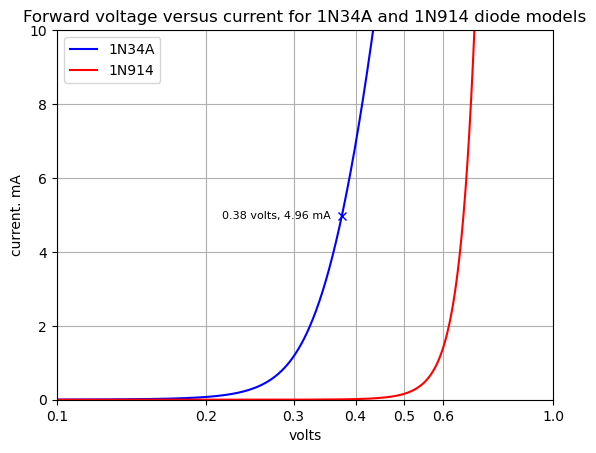

In [53]:
#| label: fig-diode_volts_current_plot
#| echo: true
#| fig-cap: Voltage vs current plot for 1N34A and 1N914 diodes.

fig1, ax1 = plt.subplots()
ax1.plot([10, 100, 1000], [1,2,3])

ax1.text(D_1N34A_voltage[1375], D_1N34A_diode_current[1375], '{:.2f} volts, {:.2f} mA   '.format(D_1N34A_voltage[1375], D_1N34A_diode_current[1375]), fontsize=8, horizontalalignment='right', verticalalignment='center')

ax1.plot(D_1N34A_voltage, D_1N34A_diode_current,'-b',label='1N34A')
ax1.plot(D_1N34A_voltage[1375], D_1N34A_diode_current[1375],'xb')

ax1.plot(D_1N914_voltage, D_1N914_diode_current,'-r',label='1N914')

ax1.set_xlim(0.1,1)
ax1.set_ylim(0,10)

ax1.set_xlabel('volts')
ax1.set_ylabel('current. mA')

ax1.set_xscale('log')
ax1.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.get_xaxis().set_tick_params(which='minor', size=0)
ax1.get_xaxis().set_tick_params(which='minor', width=0)

ax1.grid()
ax1.legend()
plt.title('Forward voltage versus current for 1N34A and 1N914 diode models')
plt.show()

As shown in the plot above, the VI curves for the 1N34A and 1N914 diode models are different. The 1N34A has a forward voltage of 0.38 volts at 5mA, whereas the 1N914 had a forward voltage of about 0.62 volts at 5mA. The shape of the two curves is also different with the 1N34A curve being a bit more rounded. The harmonics generated in audio circuits using the 1N34A will have a different set of amplitude coefficients and a different sound. 

### CMOS Switched Capacitor Voltage Converter - ICL7660
The electrical power to operate the Klon Centaur comes from the DC jack or the internal 9 volt battery. Nominally both the DC jack or the battery are 9 volt sources, however as the battery drains, the voltage will be less than 9 volts and the power source connected to the DC jack might be slightly different than 9 volts. The 9 volt power source is filtered by $C_{17}$ and $D_4$ provides reverse voltage protection. Internal to the Klon Centaur there are four power supply rails derived from the 9 volt battery or the DC jack. The 9 volts is divided by two using resistors R29 and R30 to produce +4.5V and C18 stabilizes this voltage.

$U_3$ is a CMOS switched capacitor voltage converter, part number ICL7660, which converts positive 9 volts into -9 and +18 volts. The ICL7660, with a few external components, can double, divide, or multiply a positive input voltage. The ICL7660 will operate from 1.5V to 10V input voltage and can deliver upto 10mA with a 0.5V output drop. The ICL7660 is currently produced by Renesas Electronics Corporation and Analog Devices Inc./Maxim Integrated, and distributed by Digikey under the part numbers, [ICL7660CPAZ](https://www.digikey.com/en/products/detail/renesas-electronics-corporation/ICL7660CPAZ/1034926) and [ICL7660CPA+](https://www.digikey.com/en/products/detail/analog-devices-inc-maxim-integrated/ICL7660CPA/1303023).

The Op Amps $U_1$ and $U_2$ are connected to different supply rails. $U_{1A}$ and $U_{1B}$ power supply voltages are 9 volts and ground. The signal ground is a virtual ground with a voltage of 4.5 volts. This allows audio signals processed by $U_1$ to swing between about 2 volts and 7 volts peak to peak without clipping. The power supply levels for $U_{2A}$ and $U_{2B}$ are 18 volts and -9 volts. This allows signals processed by $U_2$ to swing between about -7 to +16 volts peak to peak without clipping.

## Input Voltage and Gain Sweep
LTSpice was set up to run a series of simulations which stepped though a list of $V1$ amplitudes and values for $R_{gain}$. The frequency of $V1$ was set to 1 kHz since this is the frequency where some resonant paths peak. The voltage range used for $V1$ is 0.1 volts to 1.5 volts. The following SPICE commands were used:

```
.tran 0 5m 0
.param Rtone=5k
.param Routput=99.999k
.step param Rgain list 1 250 500 750 1k 2.5k 5k 7.5k 10k 15k 20k 25k 30k 35k 40k 45k 50k 55k 60k 65k 70k 75k 80k 85k 90k 92.5k 95k 97.5k 99.9k
.step param V1_amp list 0.1 0.25 0.5 0.75 1.0 1.25 1.5
```

The following Python reads in the data file generated by LTSpice.

In [54]:
LTSpice_data_fn = 'Sweep_Vin_&_Rgain.csv'
LTSpice_sweep_df = pd.read_csv(LTSpice_data_fn)

There are about 354,000 records in the Pandas dataframe. Voltage data was collected from the nodes listed in @tbl-sweep-node-table and a short description of the node's location in the circuit is provided.  

| Node | Description |
|---|---|
| 7 | U1A output |
| 14 | U1B output |
| 17 | right side of C10 |
| 19 | U2A output |
| 21 | U2B output |
: Nodes and connections {#tbl-sweep-node-table}

A sample of the first 5 records in the dataframe are displayed below. Each simulation run for the various $V1$ gains and $R_{gain}$ setting is delimited by _Step Information: ..._. 

In [55]:
LTSpice_sweep_df.head(5)

,time,V(7),V(14),V(17),V(19),V(21)
0,Step Information: V1_amp=100m Rgain=1 (Step: ...,NaN,NaN,NaN,NaN,NaN
1,0,4.499977,4.500065,4.500011,4.50035,4.499677
2,1.25000001460762E-08,4.499977,4.500065,4.500011,4.50035,4.499677
3,2.50000002921524E-08,4.499977,4.500065,4.500011,4.50035,4.499677
4,5.00000005843049E-08,4.499977,4.500065,4.500011,4.50035,4.499677


In the _csv_ file, there are lines of text for each new step in the simulation. For example:

_Step Information: V1_amp=100m Rgain=1K  (Step: 29/203)_

These lines of text are used to locate the index of the start of the data from each simulation sweep by looking at each record for the word 'Step' and a list of index values is created.

In [56]:
lst = LTSpice_sweep_df['time'].tolist()

step_index = []
row_cnt = 0
for i in lst:
    if 'Step' in i:
        step_index.append(row_cnt)
    row_cnt += 1

A new dataframe called _sweep_df_ is created. The following code finds the peak to peak voltage at each node for each sweep and loads the values into the dataframe.

In [57]:
sweep_df = pd.DataFrame(columns=['V1amp','Rgain','V7pp','V14pp','V17pp','V19pp','V21pp'])

for i in range(0,len(step_index)):
    #
    row_elements = LTSpice_sweep_df['time'][step_index[i]].split()

    #
    Rgain_str = row_elements[3][6:]
    Rgain_value = float(Rgain_str.replace('K', 'e3'))
    Rgain_percent = Rgain_value/100e3*100
    V1_amp_str = row_elements[2][7:]
    V1_amp_value = float(V1_amp_str.replace('m', 'e-3'))

    #
    if i == 0:
        v7_pp_value = LTSpice_sweep_df['V(7)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(7)'][0:step_index[i+1]].min()
        v14_pp_value = LTSpice_sweep_df['V(14)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(14)'][0:step_index[i+1]].min()
        v17_pp_value = LTSpice_sweep_df['V(17)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(17)'][0:step_index[i+1]].min()
        v19_pp_value = LTSpice_sweep_df['V(19)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(19)'][0:step_index[i+1]].min()
        v21_pp_value = LTSpice_sweep_df['V(21)'][0:step_index[i+1]].max() - LTSpice_sweep_df['V(21)'][0:step_index[i+1]].min()
    elif i < len(step_index)-1:
        v7_pp_value = LTSpice_sweep_df['V(7)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(7)'][step_index[i]:step_index[i+1]].min()
        v14_pp_value = LTSpice_sweep_df['V(14)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(14)'][step_index[i]:step_index[i+1]].min()
        v17_pp_value = LTSpice_sweep_df['V(17)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(17)'][step_index[i]:step_index[i+1]].min()
        v19_pp_value = LTSpice_sweep_df['V(19)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(19)'][step_index[i]:step_index[i+1]].min()        
        v21_pp_value = LTSpice_sweep_df['V(21)'][step_index[i]:step_index[i+1]].max() - LTSpice_sweep_df['V(21)'][step_index[i]:step_index[i+1]].min()        
    else:
        v7_pp_value = LTSpice_sweep_df['V(7)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(7)'][step_index[i]:-1].min()        
        v14_pp_value = LTSpice_sweep_df['V(14)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(14)'][step_index[i]:-1].min()  
        v17_pp_value = LTSpice_sweep_df['V(17)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(17)'][step_index[i]:-1].min()  
        v19_pp_value = LTSpice_sweep_df['V(19)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(19)'][step_index[i]:-1].min()   
        v21_pp_value = LTSpice_sweep_df['V(21)'][step_index[i]:-1].max() - LTSpice_sweep_df['V(21)'][step_index[i]:-1].min()          

    # load values into new dataframe
    sweep_df.loc[i] = [V1_amp_value, Rgain_percent, v7_pp_value,v14_pp_value,v17_pp_value,v19_pp_value,v21_pp_value]

The first five lines of the dataframe are displayed below.

In [58]:
sweep_df.head(5)

,V1amp,Rgain,V7pp,V14pp,V17pp,V19pp,V21pp
0,0.10,0.001,0.197555,0.000146,0.000140,0.138082,0.161292
1,0.25,0.001,0.493868,0.000367,0.000352,0.345193,0.403173
2,0.50,0.001,0.987762,0.000732,0.000703,0.690350,0.806184
3,0.75,0.001,1.481557,0.001101,0.001054,1.035477,1.209899
4,1.00,0.001,1.975554,0.001466,0.001405,1.380598,1.612327


A list of the amplitudes of $V1$ used for each sweep is created from the dataframe as well as a list of the $R_{gain}$ sweep values.

In [59]:
V1_amp_list = sweep_df['V1amp'].unique()
Rgain_list = sweep_df['Rgain'].unique()

### Op Amp saturation at Node 14 - $U_{1B}$ output
Node V14 is the output of $U_{1B}$. This is the distortion path part A. As can be seen, an input of 1.5 volts is needed to saturate the Op Amp at the lowest gain setting. At a gain setting of 50%, an input of 0.75 volts peak will drive the Op Amp into saturation. Supply rail voltages for $U_1$ are 9 volts and ground, with a virtual ground reference of 4.5 volts. This means that at some gain settings, it is likely that guitar signals with even small peak to peak amplitudes will drive $U_{1B}$ into saturation.   

The peak to peak values for $v_{14}$ are plotted versus $R_{gain}$ and $V1$.

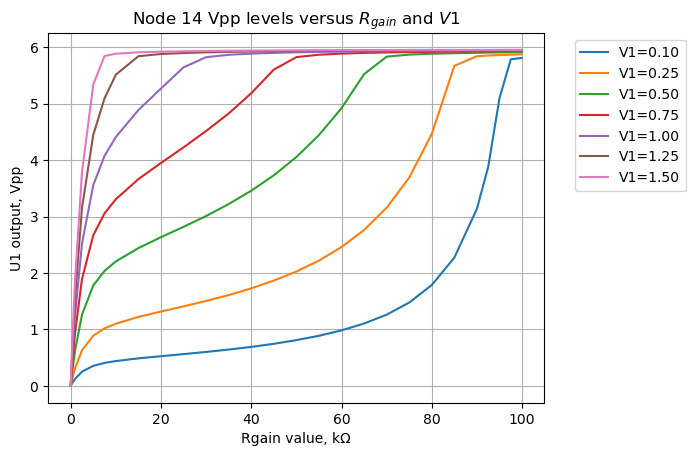

In [60]:
#| label: fig-node-14-Vpp
#| echo: true
#| fig-cap: Node 14 peak to peak voltage versus $R_{gain}$ and $V1$ input.

for i in V1_amp_list:
    plt.plot(sweep_df[sweep_df['V1amp'] == i]['Rgain'].to_numpy(),sweep_df[sweep_df['V1amp'] == i]['V14pp'].to_numpy(),'-',label = 'V1={:.2f}'.format(i))

# position legend outside the graph
plt.legend(bbox_to_anchor=(1.3,1)) # V1 legend position: relative (horizontal position, vertical position) 

plt.ylabel('U1 output, Vpp')
plt.xlabel('Rgain value, k\u03A9')

ax1.set_ylim((-0.5,6))
plt.grid()
plt.title('Node 14 Vpp levels versus $R_{gain}$ and $V1$')

plt.show()

As shown above, $U_{1B}$, maximum output swing is about 6Vpp. This is because the power rails for $U_1$ are 0 and 9V and $U_1$ is not rail-to-rail capable. The SPICE model used for the TLO72 Op Amp reproduces the maximum output signal swing. If the gain pot, $P_1$ is set midpoint, signal inputs greater than 0.75V will drive U1B's output into saturation as shown on the red curve above. This likely means that for mid range gain settings and loud guitar inputs, the guitar signal is first clipped by $U_{1B}$ and then again by the diodes. Any large harmonics generated by $U_{1B}$ will be mostly altered by $D_2$ and $D_3$.

### Guitar Output Signal Levels
Since I don't own a guitar and I'm not a guitar player, I searched online to find typical guitar signal levels. Various references such as 
[Electric Guitar Output](https://instrumentinsight.com/how-many-volts-does-an-electric-guitar-output/) and [Electric Guitar Output Voltage Levels](https://tomsguitarprojects.blogspot.com/2014/12/electric-guitar-output-voltage-levels.html) placed the guitar output level in the range of 15$\mu$V to 740mV depending on playing style, string gauge and pickup type.

The reference, [Guitar & Bass Pickup Output Voltages](https://www.sound-au.com/articles/guitar-voltage.htm), provided the following table with comments:

| Modified Maton | Neck (2.0kΩ)| Middle (N/A) | Bridge (2.0kΩ) |
|---|---|---|---|
| E1 | 40 mV  (150mV) | | 32 mV  (200mV) |
| E2 | 12 mV  (120mV) | | 20 mV  (300mV) |
|Chord | 36 mV  (200mV) | | | 36 mV (300mV) |
|Average | 29 mV  (156 mV) | | 29 mV  (267 mV)|
: Pickup Output Voltage - Averaged RMS (Peak) {#tbl-pickup-output-voltage1}

| Samick 'TV Twenty' | Neck (11.5kΩ) | Middle (11.3kΩ) | Bridge (15.3kΩ) |
|---|---|---|---|
| E1 | 44 mV  (250mV) | 76 mV  (300 mV) | 120 mV  (800 mV) |
| E2 | 12 mV  (50 mV) | 12 mV  (159 mV) | 16 mV  (200 mV) |
| Chord | 76 mV  (450 mV) | 72 mV  (400 mV) | 128 mV  (850 mV) |
| Average | 44 mV  (250 mV) | 53 mV  (283 mV) | 88 mV  (617 mV) |
: More Pickup Output Voltages {#tbl-pickup-output-voltage1}

>Tabulated results aren't especially useful, for the simple reason that there will be huge variations due to playing style, and what's being played.  However, I did summarize the results.  All numbers are millivolts (RMS) taken from the scope captures shown below.  I didn't include the bass, only the two guitars.  Note that I use light gauge strings, and you will get more level with thicker ones.  I don't have a set for comparison, but I'd expect that you could get at least 6dB (×2) more when played hard.  The pickup resistance is also shown in the table, not because it's especially useful on its own, but you can make comparisons.  It includes the parallel resistance of the volume control, as I didn't feel like dismantling my guitars for a more accurate measurement.

So it would seem possible that when playing chords, some relatively high signal levels are produced by the guitar and that saturation of $U_{1B}$'s output is likely. It seems likely to me that over driving $U_{1B}$ was a design oversight since the tone of the pedal is claimed to emanate from the hand selected Germanium diodes.

## Sinusoidal Input
In this section the transient analysis simulation results from LTSpice for the voltages at the diodes, $v_{17}$, is examined by using NumPy and SciPy functions. The input stimulus to the Klon Centaur circuit is a 1kHz sine wave. The LTSpice simulation was run with various gain settings and input amplitude values. 

A new Pandas data frame is declared with the column names shown below. In this dataframe the node voltage versus time is tabulated for each input level and gain setting. 

In [61]:
td_node_voltage_df = pd.DataFrame(columns=['V1amp','Rgain','time','V7','V14','V17','V19','V21'])

Data is loaded into the new dataframe with the following code. 

In [62]:
for i in range(0,len(step_index)):
    #
    row_elements = LTSpice_sweep_df['time'][step_index[i]].split()

    # convert the units of 'K' and 'm' to float
    Rgain_str = row_elements[3][6:]
    Rgain_value = float(Rgain_str.replace('K', 'e3'))
    Rgain_percent = Rgain_value/100e3*100
    V1_amp_str = row_elements[2][7:]
    V1_amp_value = float(V1_amp_str.replace('m', 'e-3'))

    #
    if i == 0:
        time_values = LTSpice_sweep_df['time'][1:step_index[i+1]].to_numpy()
        v7_values = LTSpice_sweep_df['V(7)'][1:step_index[i+1]].to_numpy()
        v14_values = LTSpice_sweep_df['V(14)'][1:step_index[i+1]].to_numpy()
        v17_values = LTSpice_sweep_df['V(17)'][1:step_index[i+1]].to_numpy()
        v19_values = LTSpice_sweep_df['V(19)'][1:step_index[i+1]].to_numpy()
        v21_values = LTSpice_sweep_df['V(21)'][1:step_index[i+1]].to_numpy()
    elif (i != 0) and (i < len(step_index)-1):
        time_values = LTSpice_sweep_df['time'][step_index[i]+1:step_index[i+1]].to_numpy()
        v7_values = LTSpice_sweep_df['V(7)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v14_values = LTSpice_sweep_df['V(14)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v17_values = LTSpice_sweep_df['V(17)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v19_values = LTSpice_sweep_df['V(19)'][step_index[i]+1:step_index[i+1]].to_numpy()
        v21_values = LTSpice_sweep_df['V(21)'][step_index[i]+1:step_index[i+1]].to_numpy()
    else:
        time_values = LTSpice_sweep_df['time'][step_index[i]+1:-1].to_numpy()
        v7_values = LTSpice_sweep_df['V(7)'][step_index[i]+1:-1].to_numpy()
        v14_values = LTSpice_sweep_df['V(14)'][step_index[i]+1:-1].to_numpy()
        v17_values = LTSpice_sweep_df['V(17)'][step_index[i]+1:-1].to_numpy()
        v19_values = LTSpice_sweep_df['V(19)'][step_index[i]+1:-1].to_numpy()
        v21_values = LTSpice_sweep_df['V(21)'][step_index[i]+1:-1].to_numpy()

    # load values into new dataframe
    td_node_voltage_df.loc[i] = [V1_amp_value, Rgain_percent,time_values,v7_values,v14_values,v17_values,v19_values,v21_values]

The first five records in the dataframe are displayed below.

In [63]:
td_node_voltage_df.head(5)

,V1amp,Rgain,time,V7,V14,V17,V19,V21
0,0.10,0.001,"[0, 1.25000001460762E-08, 2.50000002921524E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
1,0.25,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
2,0.50,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
3,0.75,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."
4,1.00,0.001,"[0, 6.25000007303811E-09, 1.25000001460762E-08...","[4.499977, 4.499977, 4.499977, 4.499977, 4.499...","[4.500065, 4.500065, 4.500065, 4.500065, 4.500...","[4.500011, 4.500011, 4.500011, 4.500011, 4.500...","[4.50035, 4.50035, 4.50035, 4.50035, 4.50035, ...","[4.499677, 4.499677, 4.499677, 4.499677, 4.499..."


At an offset of 127 in the dataframe, the gain setting is 60% and the input amplitude is 0.25 volts. This will produce a signal at the diodes a bit larger than the conduction threshold and the signal will be slightly voltage limited as shown in the plot below. 

In [64]:
i=127
print('Node 17, voltage vs input level V1amp={:.3f}, Rgain={:.0f}'.format(td_node_voltage_df.loc[i]['V1amp'],td_node_voltage_df.loc[i]['Rgain']))
num_samples = len(td_node_voltage_df.loc[i]['time'])
print(f'Number of samples in the simulation: {num_samples:,d}')

Node 17, voltage vs input level V1amp=0.250, Rgain=60
Number of samples in the simulation: 1,280


The bias voltage of 4.5 has been subtracted from the values in the plot.

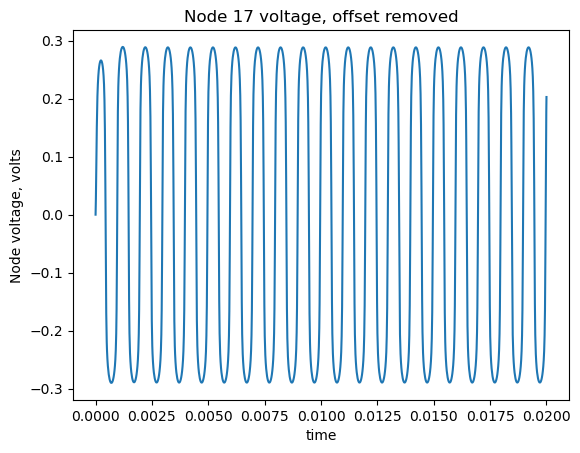

In [65]:
#| label: fig-node-17-voltage
#| echo: true
#| fig-cap: Node 17, voltage at input level V1=0.25 and Rgain=60

plt.plot(np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float),
         np.asarray(td_node_voltage_df.loc[i]['V17'], dtype=float) - 4.5,
         '-')

plt.ylabel('Node voltage, volts')
plt.xlabel('time')
#plt.grid()
plt.title('Node 17 voltage, offset removed')
plt.show()

The plot above shows the voltage at node 17. Somewhat evident is the rounding of the peaks of the waveform.

LTSpice returns the node voltages versus time where the sample interval is not uniform. LTSpice varies the time step to aid in the solution convergence. By plotting time data versus sample number we can see in the plot below, the function is not a straight line, but somewhat stair cased. 

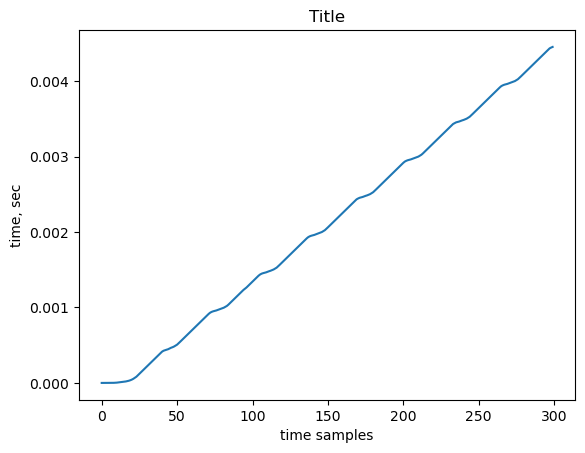

In [66]:
#| label: fig-node_17_sample_interval
#| echo: true
#| fig-cap: Node 17, sample time plotted

t_data = np.asarray(td_node_voltage_df.loc[i]['time'], dtype=float)
y_data = np.asarray(td_node_voltage_df.loc[i]['V17'], dtype=float) - 4.5

# plot the data
plt.plot(t_data[0:300])
plt.xlabel('time samples')
plt.ylabel('time, sec')
plt.title('Title')
plt.show()

We can use NumPy's function [interp](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) to resample the data so that the sample intervals are uniform.

In [67]:
stop_time = 20e-3
xnew = np.linspace(0, stop_time, int(len(t_data))) #np.linspace(0, 10, num=1001)
ynew = np.interp(xnew, t_data, y_data)

The harmonic content of the signal plotted in @fig-node-17-voltage can be examined by the use of [Fast Fourier transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). Since the simulation data ends abruptly, there is typically a non-zero value for the last data point in the simulation. A window function is typically used to minimize the "spectral leakage" associated with any discontinuities at the ends of the data set and helps to produce a more accurate representation of the signal's true frequency content.

There are many [window functions](https://en.wikipedia.org/wiki/Window_function) described in the signal processing literature. The window function used in this analysis is the [Hann function](https://en.wikipedia.org/wiki/Hann_function) and implemented by the NumPy function [hanning](https://numpy.org/doc/stable/reference/generated/numpy.hanning.html). The Hann function is a taper formed by using a weighted cosine. The window is named after Julius von Hann, often referred to as Hanning. It is also known as the raised cosine, because of its similarity to a raised-cosine distribution.

The data, window and windowed data is plotted below.

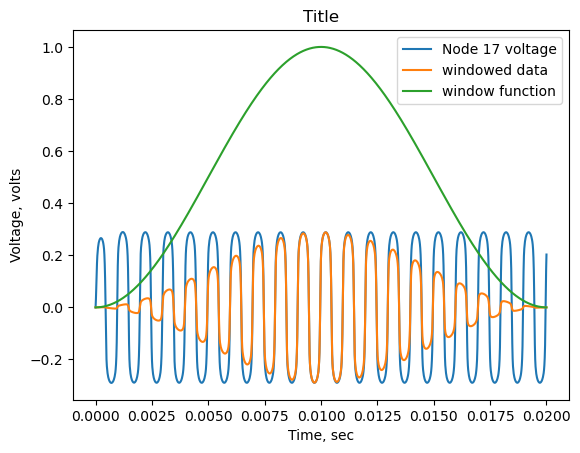

In [68]:
#| label: fig-node-17-window-and-data
#| echo: true
#| fig-cap: Node 17 voltage, window and windowed data

fft_window = np.hanning(len(xnew))
yw = ynew*fft_window

# plot the data
plt.plot(xnew,ynew)
plt.plot(xnew ,yw)
plt.plot(xnew,fft_window)
plt.xlabel('Time, sec')
plt.ylabel('Voltage, volts')
plt.legend(['Node 17 voltage', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

The plot above overlays the voltage at node 17, the window function and the windowed data.

The following code displays various parameters about the signal sample being analyzed.

In [69]:
num_samples = len(ynew)
print(f'The number of samples is: {num_samples:,.0f}')

sps = num_samples/stop_time
print(f'The sample rate is: {sps:,.0f} samples per second')

nyquist_freq = sps/2
print(f'The Nyquist frequency: {nyquist_freq:,.0f} Hz')

dt = stop_time/len(xnew)
print(f'The sample interval: {dt*1e6} \u03BCs')

The number of samples is: 1,280
The sample rate is: 64,000 samples per second
The Nyquist frequency: 32,000 Hz
The sample interval: 15.625 μs


The SciPy library includes functions to compute [discrete Fourier transforms](https://docs.scipy.org/doc/scipy/reference/fft.html), which are used in the code below to find the frequency components of the voltage at node 17. The SciPy function [fft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html) computes the one dimensional discrete Fourier Transform (DFT) using the Fast Fourier Transform (FFT) algorithm. 

In [70]:
yw_fft = scipy.fft.fft(yw)

The following code displays the frequency components of node 17 voltage. To display the amplitude spectrum in volts rms, take the two-sided amplitude amplitude spectrum and multiply the non-DC components by the square root of two and discard the second half of the array. The following equations show the calculations from a two-sided FFT to a single-sided amplitude spectrum.

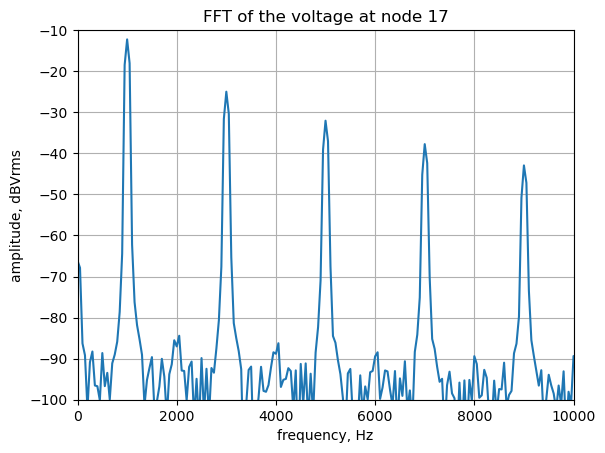

In [71]:
#| label: fig-node_17_fft
#| echo: true
#| fig-cap: Node 17, frequency spectrum.

yw_fft_ss = yw_fft[0:int(num_samples/2)] # use lower half of the array
freq = np.arange(int(num_samples/2))*sps/num_samples

k = np.ones(len(freq)) # Scaling factor is sqrt(2) except for at DC when it is 1
k[1:] = k[1:]*sqrt(2)
ywf_ss_Vrms_dB = 20*np.log10(abs(2*k*yw_fft_ss/num_samples)) # 2 is the Hann window correction factor

plt.plot(freq,ywf_ss_Vrms_dB)
plt.xlim(0,10000)
plt.ylim(-100,-10)
plt.ylabel('amplitude, dBVrms')
plt.xlabel('frequency, Hz')
plt.title('FFT of the voltage at node 17')
#plt.legend(loc='best')
plt.grid()
plt.show()

The frequency plot shows that odd harmonics are generated by the clipping action of the diodes. 

Although LTSpice can calculate the FFT of voltages or currents, Python can also be used to display the simulation results and perform additional analysis. As shown above, node voltages and branch currents can be extracted from LTSpice and brought into JupyterLab.  

## Actual Signals
A useful feature of LTSpice is capability to use _wav_ files as input signals to a circuit simulation. Actual guitar signals in the form of _wav_ files were obtained from [Sample Focus](https://samplefocus.com/). The _wav_ files are availabe under their [Standard License](https://samplefocus.com/license) and are free to use. I chose the file _clean-electric-guitar-harmonic-reality.wav_ since I thought it represented someting close to the type of signals that a player would run through their Klon Centaur. 

A transient analysis was performed using the file _Klon-Centaur_v2_wavefile.asc_ and the input source, V1, _wavefile = clean-electric-guitar-harmonic-reality.wav_ was declared as the value of V1. The simulation output was written to a _wav_ file with the directive, _.wave "klon_out.wav" 16 44.1k V(2)_. Using this file, the output of the circuit can be listened to on a computers audio player. The node voltages a several places were written to a _csv_ file to be processed and plotted by Python in this notebook. The schematic includes a pre-amp labeled as U1. The gain as been set to unity, but other gains can be obtained by adjusting the values of resistors $R_{19}$ and $R_{14}$.

The following Python modules are loaded into the JupyterLab environment in order to read _wav_ files.

In [72]:
from scipy.io import wavfile
import scipy.io

The simulation input file, _clean-electric-guitar-harmonic-reality.wav_, is loaded to the variable _wav_input_. The input file has two channels since it's a stereo recording and these are the left and right channels. The length of the audio sample and the sample rate is displayed below.

In [73]:
samplerate_input, wav_input = wavfile.read('clean-electric-guitar-harmonic-reality.wav')
length_in = wav_input.shape[0] / samplerate_input
print(f"length = {length_in} seconds")
print(f"sample rate = {samplerate_input:,.0f} sps")

length = 6.4 seconds
sample rate = 44,100 sps


Since the wave file contains stereo data, each channel is extracted, but only channel 0 is displayed.

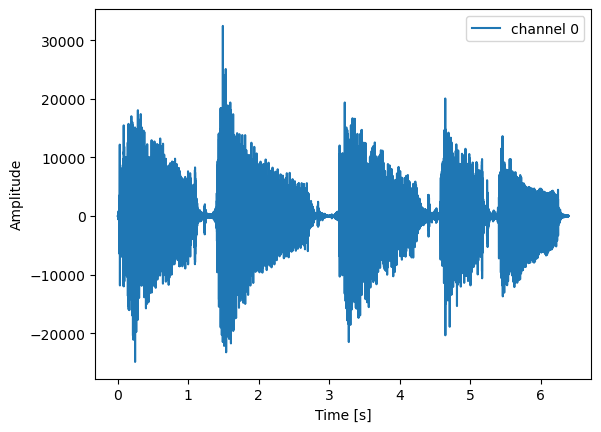

In [74]:
# split the data in channels
chan0 = np.zeros(len(wav_input))
chan1 = np.zeros(len(wav_input))

for i in range(len(wav_input)):
    chan0[i] =  wav_input[i][0]
    chan1[i] =  wav_input[i][1]    

time = np.linspace(0, length_in, len(wav_input))
plt.plot(time, chan0, label="channel 0")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

As you can see in the plot above, the input signal consists of five strums on the guitar. The amplitude of the signal in the plot above is the value of the 16 bit binary data. LTSpice converts the binary data to volts.

The following code reads the csv file saved after the simulation and places the data into a Python dataframe. Notice that the node voltage at $v_{14}$ has had the 4.5V offset removed.

In [75]:
LTSpice_wavefile_df = pd.read_csv('wavefile_Vin.csv',delimiter='\t')

The first ten lines in the dataframe are:

In [76]:
LTSpice_wavefile_df.head(10)

,time,V(1),V(2),V(14)-4.5,V(16)
0,0.000000,4.499921e-24,6.839725e-13,0.000218,7.566022e-13
1,0.000386,-3.242693e-07,-5.593652e-08,0.000217,-2.294244e-07
2,0.000392,-8.991888e-06,-2.135811e-06,0.000205,-1.153911e-05
3,0.000399,-1.766024e-05,-6.099190e-06,0.000190,-2.611201e-05
4,0.000405,-2.632934e-05,-1.194607e-05,0.000171,-4.394813e-05
5,0.000412,-3.499917e-05,-1.967646e-05,0.000149,-6.504747e-05
6,0.000418,-4.366974e-05,-2.929036e-05,0.000123,-8.941003e-05
7,0.000424,-5.234105e-05,-4.078776e-05,0.000094,-1.170358e-04
8,0.000431,-6.101310e-05,-5.416866e-05,0.000061,-1.479248e-04
9,0.000437,-7.730443e-05,-7.190395e-05,0.000018,-1.888111e-04


The data is saved to several NumPy arrays to be processed and displayed using Python. Of interest are the input and output nodes, $v_1$ and $v_2$, as well as the nodes $v_{14}$ and $v_{16}$.

In [77]:
t_data = np.asarray(LTSpice_wavefile_df['time'], dtype=float)
v1_data = np.asarray(LTSpice_wavefile_df['V(1)'], dtype=float)
v2_data = np.asarray(LTSpice_wavefile_df['V(2)'], dtype=float)
v14_data = np.asarray(LTSpice_wavefile_df['V(14)-4.5'], dtype=float)
v16_data = np.asarray(LTSpice_wavefile_df['V(16)'], dtype=float)

The following code plots the voltage at nodes $v_1$ and $v_2$, which are the input and output nodes of the Klon Centaur. Only the first 54 ms or so is plotted.

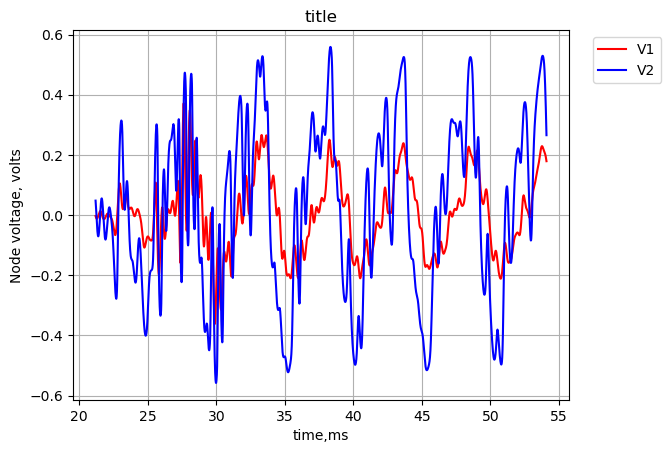

In [78]:
#| label: fig-actual-signals-node-voltage-plot
#| fig-cap: Actual signals caption

start_index = 3500
stop_index = 10000
plt.plot(t_data[start_index:stop_index]*1000,v1_data[start_index:stop_index],'-r',label='V1')
#plt.plot(t_data[start_index:stop_index]*1000,v16_data[start_index:stop_index],'-',label='V16')
#plt.plot(t_data[start_index:stop_index]*1000,v14_data[start_index:stop_index],'-',label='V14')
plt.plot(t_data[start_index:stop_index]*1000,v2_data[start_index:stop_index],'-b',label='V2')

plt.ylabel('Node voltage, volts')
plt.xlabel('time,ms')
plt.grid()
plt.title('title')

#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

The plot above shows the pedal has some gain applied to the signal. The fundamental frequency appears the same, but the overall waveform is much different, as would be expected since the pedal is modifying the input signal with filtering and amplitude clipping by the diodes. 

The plot below shows the voltage plots for node $v_{14}$, the output terminal of $U_{1B}$ and $v_{16}$, the voltage on $D_2$.

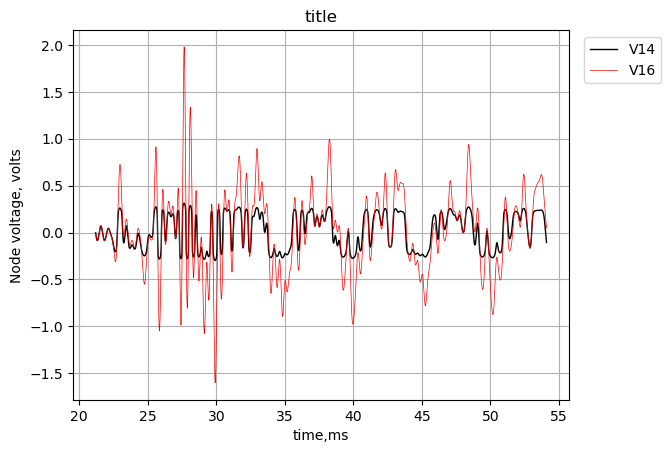

In [79]:
start_index = 3500
stop_index = 10000
#plt.plot(t_data[start_index:stop_index]*1000,v1_data[start_index:stop_index],'-',label='V1')
plt.plot(t_data[start_index:stop_index]*1000,v16_data[start_index:stop_index],'-k', linewidth=1, label='V14')
plt.plot(t_data[start_index:stop_index]*1000,v14_data[start_index:stop_index],'-r', linewidth=0.5, label='V16')
#plt.plot(t_data[start_index:stop_index]*1000,v2_data[start_index:stop_index],'-',label='V2')

plt.ylabel('Node voltage, volts')
plt.xlabel('time,ms')
plt.grid()
plt.title('title')

#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

The plot above shows the amplitude limiting caused by the diodes on the signal. 

From here additional numerical analysis of the node voltages can be performed within the JupyterLab notebook using the signal processing code of NumPy and SciPy. Python's numerical analysis capability can be combined with circuit simulation results from LTSpice and actual physical measurements of prototype circuits to aid the designer in the analysis and development of electronic circuits.

## Comparison of MNA and LTSpice results {#sec-Comparison_of_MNA_and_LTSpice_results}
In this section the solutions obtained from MNA and LTSpice will be compared to each other. As shown below the two solutions are very comparable which allows us to have a high degree of confidence in the accuracy of the MNA solution. 

The netlist for the MNA solution was obtained from @fig-Klon-Centaur_sch and the schematic of @fig-Klon-Centaur_v2_sch was used for the LTSpice simulation. For the MNA solution, the diodes, $D_2$ and $D_3$ were removed from the netlist by inserting an asterisk at the start of those lines which turn the lines into comments, shown below. Additionally, the MNA netlist treats the Op Amps as ideal Op Amps. In the LTSpice simulation, device modules are used for the diodes and Op Amps. This will add some accuracy to the simulation. The amplitude of the input signal, $V1$, in the LTSpice simulation was chosen to be $\pm25 mV$ in the transient simulations, so that the diodes would not be conducting. This keeps both the MNA and the LTSpice solutions in the linear domain.

The MNA solution is presented first, followed by loading and reading the exported LTSpice simulation results which were exported as a _csv_ file. The two solutions are plotted on the same graph so that the results can be compared.

The netlist for the circuit in @fig-Klon-Centaur_sch, was exported and shown below. 

In [80]:
net_list = '''
* Klon-Centaur_v1.asc
V1 1 0 1
R1 3 1 10e3
R2 0 4 1000e3
C1 4 3 100e-9
R5 7 25 5.1e3
R8 25 0 1.5e3
C3 8 7 100e-9
C4 7 25 68e-9
C6 25 26 390e-9
R9 26 0 1e3
R6 9 8 10e3
C5 9 8 68e-9
Rp1b2 25 27 50e3
Rp1a2 27 0 50e3
Rp1b1 11 0 50e3
Rp1a1 0 9 50e3
R10 12 11 2e3
R11 13 12 15e3
C7 13 12 82e-9
C8 14 13 390e-12
R12 14 13 422e3
R13 16 15 1e3
C11 17 28 2.2e-9
R15 28 27 22e3
R17 18 27 27e3
R18 29 27 12e3
C12 18 29 27e-9
R16 18 17 47e3
R7 8 10 1.5e3
R24 18 10 15e3
R20 19 18 392e3
C13 19 18 820e-12
R21 19 32 1.8e3
R22 20 19 100e3
Rp2a 32 30 5e3
Rp2b 30 31 5e3
C14 20 30 3.9e-9
R241 21 20 100e3
R25 23 22 560
R23 21 31 4.7e3
O1a 7 4 7
O1b 13 9 14
O2a 18 0 19
O2b 20 0 21
R3 5 0 100e3
R4 6 5 560
*D2 0 16 1N34A
*D3 16 0 1N34A
C2 7 5 4.7e-6
C16 10 0 1e-6
C9 14 15 1e-6
C10 17 16 1e-6
C15 21 22 4.7e-6
R26 2 6 68e3
R28 2 0 100e3
Rp3a 23 24 50e3
Rp3b 24 0 50e3
R27 2 24 0.01
'''

The symbolic modified nodal analysis function is called with the netlist and the MNA results are returned.

In [81]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The netlist report provides some statistics about the circuit, which are printed below.  

In [82]:
print(report)

Net list report
number of lines in netlist: 56
number of branches: 52
number of nodes: 32
number of unknown currents: 5
number of RLC (passive components): 51
number of resistors: 35
number of capacitors: 16
number of inductors: 0
number of independent voltage sources: 1
number of independent current sources: 0
number of Op Amps: 4
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0



There are 32 nodes and 5 unknown currents in the circuit. This means that the MNA technique will generate a system of 37 equations for SymPy to solve.

The network equations are assembled with the following lines of Python code.

In [83]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

The system of equations is displayed with the following code using the markdown function. 

In [84]:
# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_sym.rhs[i]),latex(NE_sym.lhs[i]))
Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}}$<br>$0 = v_{2} \cdot \left(\frac{1}{R_{28}} + \frac{1}{R_{27}} + \frac{1}{R_{26}}\right) - \frac{v_{24}}{R_{27}} - \frac{v_{6}}{R_{26}}$<br>$0 = - C_{1} s v_{4} + v_{3} \left(C_{1} s + \frac{1}{R_{1}}\right) - \frac{v_{1}}{R_{1}}$<br>$0 = - C_{1} s v_{3} + v_{4} \left(C_{1} s + \frac{1}{R_{2}}\right)$<br>$0 = - C_{2} s v_{7} + v_{5} \left(C_{2} s + \frac{1}{R_{4}} + \frac{1}{R_{3}}\right) - \frac{v_{6}}{R_{4}}$<br>$0 = v_{6} \cdot \left(\frac{1}{R_{4}} + \frac{1}{R_{26}}\right) - \frac{v_{5}}{R_{4}} - \frac{v_{2}}{R_{26}}$<br>$0 = - C_{2} s v_{5} - C_{3} s v_{8} + I_{O1a} + v_{25} \left(- C_{4} s - \frac{1}{R_{5}}\right) + v_{7} \left(C_{2} s + C_{3} s + C_{4} s + \frac{1}{R_{5}}\right)$<br>$0 = - C_{3} s v_{7} + v_{8} \left(C_{3} s + C_{5} s + \frac{1}{R_{7}} + \frac{1}{R_{6}}\right) + v_{9} \left(- C_{5} s - \frac{1}{R_{6}}\right) - \frac{v_{10}}{R_{7}}$<br>$0 = v_{8} \left(- C_{5} s - \frac{1}{R_{6}}\right) + v_{9} \left(C_{5} s + \frac{1}{Rp1a1} + \frac{1}{R_{6}}\right)$<br>$0 = v_{10} \left(C_{16} s + \frac{1}{R_{7}} + \frac{1}{R_{24}}\right) - \frac{v_{8}}{R_{7}} - \frac{v_{18}}{R_{24}}$<br>$0 = v_{11} \cdot \left(\frac{1}{Rp1b1} + \frac{1}{R_{10}}\right) - \frac{v_{12}}{R_{10}}$<br>$0 = v_{12} \left(C_{7} s + \frac{1}{R_{11}} + \frac{1}{R_{10}}\right) + v_{13} \left(- C_{7} s - \frac{1}{R_{11}}\right) - \frac{v_{11}}{R_{10}}$<br>$0 = v_{12} \left(- C_{7} s - \frac{1}{R_{11}}\right) + v_{13} \left(C_{7} s + C_{8} s + \frac{1}{R_{12}} + \frac{1}{R_{11}}\right) + v_{14} \left(- C_{8} s - \frac{1}{R_{12}}\right)$<br>$0 = - C_{9} s v_{15} + I_{O1b} + v_{13} \left(- C_{8} s - \frac{1}{R_{12}}\right) + v_{14} \left(C_{8} s + C_{9} s + \frac{1}{R_{12}}\right)$<br>$0 = - C_{9} s v_{14} + v_{15} \left(C_{9} s + \frac{1}{R_{13}}\right) - \frac{v_{16}}{R_{13}}$<br>$0 = - C_{10} s v_{17} + v_{16} \left(C_{10} s + \frac{1}{R_{13}}\right) - \frac{v_{15}}{R_{13}}$<br>$0 = - C_{10} s v_{16} - C_{11} s v_{28} + v_{17} \left(C_{10} s + C_{11} s + \frac{1}{R_{16}}\right) - \frac{v_{18}}{R_{16}}$<br>$0 = - C_{12} s v_{29} + v_{18} \left(C_{12} s + C_{13} s + \frac{1}{R_{24}} + \frac{1}{R_{20}} + \frac{1}{R_{17}} + \frac{1}{R_{16}}\right) + v_{19} \left(- C_{13} s - \frac{1}{R_{20}}\right) - \frac{v_{10}}{R_{24}} - \frac{v_{27}}{R_{17}} - \frac{v_{17}}{R_{16}}$<br>$0 = I_{O2a} + v_{18} \left(- C_{13} s - \frac{1}{R_{20}}\right) + v_{19} \left(C_{13} s + \frac{1}{R_{22}} + \frac{1}{R_{21}} + \frac{1}{R_{20}}\right) - \frac{v_{20}}{R_{22}} - \frac{v_{32}}{R_{21}}$<br>$0 = - C_{14} s v_{30} + v_{20} \left(C_{14} s + \frac{1}{R_{241}} + \frac{1}{R_{22}}\right) - \frac{v_{21}}{R_{241}} - \frac{v_{19}}{R_{22}}$<br>$0 = - C_{15} s v_{22} + I_{O2b} + v_{21} \left(C_{15} s + \frac{1}{R_{241}} + \frac{1}{R_{23}}\right) - \frac{v_{20}}{R_{241}} - \frac{v_{31}}{R_{23}}$<br>$0 = - C_{15} s v_{21} + v_{22} \left(C_{15} s + \frac{1}{R_{25}}\right) - \frac{v_{23}}{R_{25}}$<br>$0 = v_{23} \cdot \left(\frac{1}{Rp3a} + \frac{1}{R_{25}}\right) - \frac{v_{24}}{Rp3a} - \frac{v_{22}}{R_{25}}$<br>$0 = v_{24} \cdot \left(\frac{1}{Rp3b} + \frac{1}{Rp3a} + \frac{1}{R_{27}}\right) - \frac{v_{23}}{Rp3a} - \frac{v_{2}}{R_{27}}$<br>$0 = - C_{6} s v_{26} + v_{25} \left(C_{4} s + C_{6} s + \frac{1}{Rp1b2} + \frac{1}{R_{8}} + \frac{1}{R_{5}}\right) + v_{7} \left(- C_{4} s - \frac{1}{R_{5}}\right) - \frac{v_{27}}{Rp1b2}$<br>$0 = - C_{6} s v_{25} + v_{26} \left(C_{6} s + \frac{1}{R_{9}}\right)$<br>$0 = v_{27} \cdot \left(\frac{1}{Rp1b2} + \frac{1}{Rp1a2} + \frac{1}{R_{18}} + \frac{1}{R_{17}} + \frac{1}{R_{15}}\right) - \frac{v_{25}}{Rp1b2} - \frac{v_{29}}{R_{18}} - \frac{v_{18}}{R_{17}} - \frac{v_{28}}{R_{15}}$<br>$0 = - C_{11} s v_{17} + v_{28} \left(C_{11} s + \frac{1}{R_{15}}\right) - \frac{v_{27}}{R_{15}}$<br>$0 = - C_{12} s v_{18} + v_{29} \left(C_{12} s + \frac{1}{R_{18}}\right) - \frac{v_{27}}{R_{18}}$<br>$0 = - C_{14} s v_{20} + v_{30} \left(C_{14} s + \frac{1}{Rp2b} + \frac{1}{Rp2a}\right) - \frac{v_{31}}{Rp2b} - \frac{v_{32}}{Rp2a}$<br>$0 = v_{31} \cdot \left(\frac{1}{Rp2b} + \frac{1}{R_{23}}\right) - \frac{v_{30}}{Rp2b} - \frac{v_{21}}{R_{23}}$<br>$0 = v_{32} \cdot \left(\frac{1}{Rp2a} + \frac{1}{R_{21}}\right) - \frac{v_{30}}{Rp2a} - \frac{v_{19}}{R_{21}}$<br>$V_{1} = v_{1}$<br>$0 = - v_{4} + v_{7}$<br>$0 = v_{13} - v_{9}$<br>$0 = v_{18}$<br>$0 = v_{20}$<br>

There are too many equations and symbols for SymPy to obtain a symbolic solution and symbolic results would not be useful.

The following code is used to turn the free symbols into SymPy variables and the numeric values for the components are put into a Python dictionary.

In [85]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
element_values = SymMNA.get_part_values(network_df)

### Numerical Solution
As shown below, the value of $V1$ is set to one. The value of $V1$ gets canceled in the voltage transfer function, so this value does not affect the solution. The bypass switch is put into the effects position by setting the values of $R_{26}$ and $R_{27}$. The controls on the Klon Centaur are set to mid position.

In [86]:
element_values[V1] = 1

# bypass switch in effects position
element_values[R26] = 68e3
element_values[R27] = 0.01

# gain pot, P1
P1_value = 100e3
P1_setting = 0.5 # a percent of full scale
element_values[Rp1b2] = P1_setting*P1_value
element_values[Rp1a2] = P1_value - P1_setting*P1_value
element_values[Rp1b1] = P1_setting*P1_value
element_values[Rp1a1] = P1_value - P1_setting*P1_value

# treble pot, P2
P2_value = 10e3
P2_setting = 0.5
element_values[Rp2b] = P2_setting*P2_value
element_values[Rp2a] = P2_value - P2_setting*P2_value

#output pot, P3
P3_value = 100e3
P3_setting = 0.5
element_values[Rp3b] = P3_setting*P3_value
element_values[Rp3a] = P3_value - P3_setting*P3_value

The following code replaces the symbols in the network equations with numerical values and displays the equations.

In [87]:
NE = NE_sym.subs(element_values)

temp = ''
for i in range(shape(NE.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE.rhs[i]),latex(NE.lhs[i]))

Markdown(temp)

$0 = I_{V1} + 0.0001 v_{1} - 0.0001 v_{3}$<br>$0 = 100.000024705882 v_{2} - 100.0 v_{24} - 1.47058823529412 \cdot 10^{-5} v_{6}$<br>$0 = - 1.0 \cdot 10^{-7} s v_{4} - 0.0001 v_{1} + v_{3} \cdot \left(1.0 \cdot 10^{-7} s + 0.0001\right)$<br>$0 = - 1.0 \cdot 10^{-7} s v_{3} + v_{4} \cdot \left(1.0 \cdot 10^{-7} s + 1.0 \cdot 10^{-6}\right)$<br>$0 = - 4.7 \cdot 10^{-6} s v_{7} + v_{5} \cdot \left(4.7 \cdot 10^{-6} s + 0.00179571428571429\right) - 0.00178571428571429 v_{6}$<br>$0 = - 1.47058823529412 \cdot 10^{-5} v_{2} - 0.00178571428571429 v_{5} + 0.00180042016806723 v_{6}$<br>$0 = I_{O1a} - 4.7 \cdot 10^{-6} s v_{5} - 1.0 \cdot 10^{-7} s v_{8} + v_{25} \left(- 6.8 \cdot 10^{-8} s - 0.000196078431372549\right) + v_{7} \cdot \left(4.868 \cdot 10^{-6} s + 0.000196078431372549\right)$<br>$0 = - 1.0 \cdot 10^{-7} s v_{7} - 0.000666666666666667 v_{10} + v_{8} \cdot \left(1.68 \cdot 10^{-7} s + 0.000766666666666667\right) + v_{9} \left(- 6.8 \cdot 10^{-8} s - 0.0001\right)$<br>$0 = v_{8} \left(- 6.8 \cdot 10^{-8} s - 0.0001\right) + v_{9} \cdot \left(6.8 \cdot 10^{-8} s + 0.00012\right)$<br>$0 = v_{10} \cdot \left(1.0 \cdot 10^{-6} s + 0.000733333333333333\right) - 6.66666666666667 \cdot 10^{-5} v_{18} - 0.000666666666666667 v_{8}$<br>$0 = 0.00052 v_{11} - 0.0005 v_{12}$<br>$0 = - 0.0005 v_{11} + v_{12} \cdot \left(8.2 \cdot 10^{-8} s + 0.000566666666666667\right) + v_{13} \left(- 8.2 \cdot 10^{-8} s - 6.66666666666667 \cdot 10^{-5}\right)$<br>$0 = v_{12} \left(- 8.2 \cdot 10^{-8} s - 6.66666666666667 \cdot 10^{-5}\right) + v_{13} \cdot \left(8.239 \cdot 10^{-8} s + 6.90363349131122 \cdot 10^{-5}\right) + v_{14} \left(- 3.9 \cdot 10^{-10} s - 2.3696682464455 \cdot 10^{-6}\right)$<br>$0 = I_{O1b} - 1.0 \cdot 10^{-6} s v_{15} + v_{13} \left(- 3.9 \cdot 10^{-10} s - 2.3696682464455 \cdot 10^{-6}\right) + v_{14} \cdot \left(1.00039 \cdot 10^{-6} s + 2.3696682464455 \cdot 10^{-6}\right)$<br>$0 = - 1.0 \cdot 10^{-6} s v_{14} + v_{15} \cdot \left(1.0 \cdot 10^{-6} s + 0.001\right) - 0.001 v_{16}$<br>$0 = - 1.0 \cdot 10^{-6} s v_{17} - 0.001 v_{15} + v_{16} \cdot \left(1.0 \cdot 10^{-6} s + 0.001\right)$<br>$0 = - 1.0 \cdot 10^{-6} s v_{16} - 2.2 \cdot 10^{-9} s v_{28} + v_{17} \cdot \left(1.0022 \cdot 10^{-6} s + 2.12765957446809 \cdot 10^{-5}\right) - 2.12765957446809 \cdot 10^{-5} v_{18}$<br>$0 = - 2.7 \cdot 10^{-8} s v_{29} - 6.66666666666667 \cdot 10^{-5} v_{10} - 2.12765957446809 \cdot 10^{-5} v_{17} + v_{18} \cdot \left(2.782 \cdot 10^{-8} s + 0.000127531319856548\right) + v_{19} \left(- 8.2 \cdot 10^{-10} s - 2.55102040816327 \cdot 10^{-6}\right) - 3.7037037037037 \cdot 10^{-5} v_{27}$<br>$0 = I_{O2a} + v_{18} \left(- 8.2 \cdot 10^{-10} s - 2.55102040816327 \cdot 10^{-6}\right) + v_{19} \cdot \left(8.2 \cdot 10^{-10} s + 0.000568106575963719\right) - 1.0 \cdot 10^{-5} v_{20} - 0.000555555555555556 v_{32}$<br>$0 = - 3.9 \cdot 10^{-9} s v_{30} - 1.0 \cdot 10^{-5} v_{19} + v_{20} \cdot \left(3.9 \cdot 10^{-9} s + 2.0 \cdot 10^{-5}\right) - 1.0 \cdot 10^{-5} v_{21}$<br>$0 = I_{O2b} - 4.7 \cdot 10^{-6} s v_{22} - 1.0 \cdot 10^{-5} v_{20} + v_{21} \cdot \left(4.7 \cdot 10^{-6} s + 0.000222765957446809\right) - 0.000212765957446809 v_{31}$<br>$0 = - 4.7 \cdot 10^{-6} s v_{21} + v_{22} \cdot \left(4.7 \cdot 10^{-6} s + 0.00178571428571429\right) - 0.00178571428571429 v_{23}$<br>$0 = - 0.00178571428571429 v_{22} + 0.00180571428571429 v_{23} - 2.0 \cdot 10^{-5} v_{24}$<br>$0 = - 100.0 v_{2} - 2.0 \cdot 10^{-5} v_{23} + 100.00004 v_{24}$<br>$0 = - 3.9 \cdot 10^{-7} s v_{26} + v_{25} \cdot \left(4.58 \cdot 10^{-7} s + 0.000882745098039216\right) - 2.0 \cdot 10^{-5} v_{27} + v_{7} \left(- 6.8 \cdot 10^{-8} s - 0.000196078431372549\right)$<br>$0 = - 3.9 \cdot 10^{-7} s v_{25} + v_{26} \cdot \left(3.9 \cdot 10^{-7} s + 0.001\right)$<br>$0 = - 3.7037037037037 \cdot 10^{-5} v_{18} - 2.0 \cdot 10^{-5} v_{25} + 0.000205824915824916 v_{27} - 4.54545454545455 \cdot 10^{-5} v_{28} - 8.33333333333333 \cdot 10^{-5} v_{29}$<br>$0 = - 2.2 \cdot 10^{-9} s v_{17} - 4.54545454545455 \cdot 10^{-5} v_{27} + v_{28} \cdot \left(2.2 \cdot 10^{-9} s + 4.54545454545455 \cdot 10^{-5}\right)$<br>$0 = - 2.7 \cdot 10^{-8} s v_{18} - 8.33333333333333 \cdot 10^{-5} v_{27} + v_{29} \cdot \left(2.7 \cdot 10^{-8} s + 8.33333333333333 \cdot 10^{-5}\right)$<br>$0 = - 3.9 \cdot 10^{-9} s v_{20} + v_{30} \cdot \left(3.9 \cdot 10^{-9} s + 0.0004\right) - 0.0002 v_{31} - 0.0002 v_{32}$<br>$0 = - 0.000212765957446809 v_{21} - 0.0002 v_{30} + 0.000412765957446809 v_{31}$<br>$0 = - 0.000555555555555556 v_{19} - 0.0002 v_{30} + 0.000755555555555556 v_{32}$<br>$1 = v_{1}$<br>$0 = - v_{4} + v_{7}$<br>$0 = v_{13} - v_{9}$<br>$0 = v_{18}$<br>$0 = v_{20}$<br>

Solve for voltages and currents and display the results.

In [88]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = 1.0$<br>$v_{2} = \frac{1.60460486959839 \cdot 10^{204} s^{15} + 3.27859737275232 \cdot 10^{209} s^{14} + 2.24239224921523 \cdot 10^{214} s^{13} + 6.17846960611372 \cdot 10^{218} s^{12} + 6.98631389088568 \cdot 10^{222} s^{11} + 3.84144613823827 \cdot 10^{226} s^{10} + 1.14176089090876 \cdot 10^{230} s^{9} + 1.9487479169721 \cdot 10^{233} s^{8} + 1.9264469914375 \cdot 10^{236} s^{7} + 1.04007382786928 \cdot 10^{239} s^{6} + 2.4949612511751 \cdot 10^{241} s^{5} + 8.71156576910649 \cdot 10^{242} s^{4} + 1.59377116458413 \cdot 10^{244} s^{3} + 5.83569842526406 \cdot 10^{244} s^{2}}{7.15162708944972 \cdot 10^{204} s^{15} + 5.22082517544816 \cdot 10^{209} s^{14} + 1.46041562741045 \cdot 10^{214} s^{13} + 2.09213705503726 \cdot 10^{218} s^{12} + 1.72594223118152 \cdot 10^{222} s^{11} + 8.6526522592516 \cdot 10^{225} s^{10} + 2.69139767992792 \cdot 10^{229} s^{9} + 5.18883010414778 \cdot 10^{232} s^{8} + 6.05076928322552 \cdot 10^{235} s^{7} + 3.99892189278975 \cdot 10^{238} s^{6} + 1.28045462753876 \cdot 10^{241} s^{5} + 1.26937201271651 \cdot 10^{243} s^{4} + 4.49019318895868 \cdot 10^{244} s^{3} + 5.35281780941488 \cdot 10^{245} s^{2} + 2.32475885320685 \cdot 10^{246} s + 3.10810663331814 \cdot 10^{246}}$<br>$v_{3} = \frac{100.0 s + 1000.0}{101.0 s + 1000.0}$<br>$v_{4} = \frac{100.0 s}{101.0 s + 1000.0}$<br>$v_{5} = \frac{7.08081890044526 \cdot 10^{204} s^{15} + 5.16811216386491 \cdot 10^{209} s^{14} + 1.44527574255849 \cdot 10^{214} s^{13} + 2.06993156176013 \cdot 10^{218} s^{12} + 1.70763881138264 \cdot 10^{222} s^{11} + 8.56283170735283 \cdot 10^{225} s^{10} + 2.66372688771691 \cdot 10^{229} s^{9} + 5.13265459135094 \cdot 10^{232} s^{8} + 5.97388273658386 \cdot 10^{235} s^{7} + 3.92904920853072 \cdot 10^{238} s^{6} + 1.24088217015922 \cdot 10^{241} s^{5} + 1.14762193670536 \cdot 10^{243} s^{4} + 2.99189745426633 \cdot 10^{244} s^{3} + 9.40378060745908 \cdot 10^{244} s^{2}}{7.15162708944972 \cdot 10^{204} s^{15} + 5.22082517544816 \cdot 10^{209} s^{14} + 1.46041562741045 \cdot 10^{214} s^{13} + 2.09213705503726 \cdot 10^{218} s^{12} + 1.72594223118152 \cdot 10^{222} s^{11} + 8.6526522592516 \cdot 10^{225} s^{10} + 2.69139767992792 \cdot 10^{229} s^{9} + 5.18883010414778 \cdot 10^{232} s^{8} + 6.05076928322552 \cdot 10^{235} s^{7} + 3.99892189278975 \cdot 10^{238} s^{6} + 1.28045462753876 \cdot 10^{241} s^{5} + 1.26937201271651 \cdot 10^{243} s^{4} + 4.49019318895868 \cdot 10^{244} s^{3} + 5.35281780941488 \cdot 10^{245} s^{2} + 2.32475885320685 \cdot 10^{246} s + 3.10810663331814 \cdot 10^{246}}$<br>$v_{6} = \frac{7.03608903088174 \cdot 10^{204} s^{15} + 5.15267855413586 \cdot 10^{209} s^{14} + 1.45178661250784 \cdot 10^{214} s^{13} + 2.10349021556464 \cdot 10^{218} s^{12} + 1.75075517725956 \cdot 10^{222} s^{11} + 8.80666065452342 \cdot 10^{225} s^{10} + 2.73522884121702 \cdot 10^{229} s^{9} + 5.24990520050914 \cdot 10^{232} s^{8} + 6.08244062485052 \cdot 10^{235} s^{7} + 3.9819101460933 \cdot 10^{238} s^{6} + 1.25112552321302 \cdot 10^{241} s^{5} + 1.14536375990424 \cdot 10^{243} s^{4} + 2.98047751957814 \cdot 10^{244} s^{3} + 9.37463641227194 \cdot 10^{244} s^{2}}{7.15162708944972 \cdot 10^{204} s^{15} + 5.22082517544816 \cdot 10^{209} s^{14} + 1.46041562741045 \cdot 10^{214} s^{13} + 2.09213705503726 \cdot 10^{218} s^{12} + 1.72594223118152 \cdot 10^{222} s^{11} + 8.6526522592516 \cdot 10^{225} s^{10} + 2.69139767992792 \cdot 10^{229} s^{9} + 5.18883010414778 \cdot 10^{232} s^{8} + 6.05076928322552 \cdot 10^{235} s^{7} + 3.99892189278975 \cdot 10^{238} s^{6} + 1.28045462753876 \cdot 10^{241} s^{5} + 1.26937201271651 \cdot 10^{243} s^{4} + 4.49019318895868 \cdot 10^{244} s^{3} + 5.35281780941488 \cdot 10^{245} s^{2} + 2.32475885320685 \cdot 10^{246} s + 3.10810663331814 \cdot 10^{246}}$<br>$v_{7} = \frac{100.0 s}{101.0 s + 1000.0}$<br>$v_{8} = \frac{1.53 \cdot 10^{27} s^{4} + 3.822 \cdot 10^{30} s^{3} + 1.98 \cdot 10^{33} s^{2}}{1.5453 \cdot 10^{27} s^{4} + 1.448658 \cdot 10^{31} s^{3} + 2.1691024 \cdot 10^{34} s^{2} + 1.758644 \cdot 10^{36} s + 1.53 \cdot 10^{37}}$<br>$v_{9} = \frac{1.53 \cdot 10^{27} s^{4} + 3.372 \cdot 10^{30} s^{3} + 1.65 \cdot 10^{33} s^{2}}{1.5453 \cdot 10^{27} s^{4} + 1.448658 \cdot 10^{31} s^{3} + 2.1691024 \cdot 10^{34} s^{2} + 1.758644 \cdot 10^{36} s + 1.53 \cdot 10^{37}}$<br>$v_{10} = \frac{1.02 \cdot 10^{30} s^{3} + 1.8 \cdot 10^{33} s^{2}}{1.5453 \cdot 10^{27} s^{4} + 1.448658 \cdot 10^{31} s^{3} + 2.1691024 \cdot 10^{34} s^{2} + 1.758644 \cdot 10^{36} s + 1.53 \cdot 10^{37}}$<br>$v_{11} = \frac{1.56825 \cdot 10^{39} s^{5} + 4.7313 \cdot 10^{42} s^{4} + 4.50125 \cdot 10^{45} s^{3} + 1.375 \cdot 10^{48} s^{2}}{1.6472898 \cdot 10^{39} s^{5} + 1.716827928 \cdot 10^{43} s^{4} + 3.92993125840001 \cdot 10^{46} s^{3} + 2.60963579706668 \cdot 10^{49} s^{2} + 1.98012893333334 \cdot 10^{51} s + 1.70850000000001 \cdot 10^{52}}$<br>$v_{12} = \frac{1.63098 \cdot 10^{39} s^{5} + 4.920552 \cdot 10^{42} s^{4} + 4.6813 \cdot 10^{45} s^{3} + 1.43 \cdot 10^{48} s^{2}}{1.6472898 \cdot 10^{39} s^{5} + 1.716827928 \cdot 10^{43} s^{4} + 3.92993125840001 \cdot 10^{46} s^{3} + 2.60963579706668 \cdot 10^{49} s^{2} + 1.98012893333334 \cdot 10^{51} s + 1.70850000000001 \cdot 10^{52}}$<br>$v_{13} = \frac{1.53 \cdot 10^{27} s^{4} + 3.372 \cdot 10^{30} s^{3} + 1.65 \cdot 10^{33} s^{2}}{1.5453 \cdot 10^{27} s^{4} + 1.448658 \cdot 10^{31} s^{3} + 2.1691024 \cdot 10^{34} s^{2} + 1.758644 \cdot 10^{36} s + 1.53 \cdot 10^{37}}$<br>$v_{14} = \frac{1.2721644 \cdot 10^{48} s^{6} + 7.45961435931766 \cdot 10^{52} s^{5} + 2.18693901867302 \cdot 10^{56} s^{4} + 2.07668666587681 \cdot 10^{59} s^{3} + 6.37322274881527 \cdot 10^{61} s^{2}}{1.284886044 \cdot 10^{48} s^{6} + 2.11983185019071 \cdot 10^{52} s^{5} + 1.12019716327369 \cdot 10^{56} s^{4} + 2.06607825492002 \cdot 10^{59} s^{3} + 1.25223922229928 \cdot 10^{62} s^{2} + 9.39782361437604 \cdot 10^{63} s + 8.09715639810431 \cdot 10^{64}}$<br>$v_{15} = \frac{6.12932264586913 \cdot 10^{102} s^{11} + 6.51555635737714 \cdot 10^{107} s^{10} + 2.17603109429572 \cdot 10^{112} s^{9} + 2.68844248892112 \cdot 10^{116} s^{8} + 1.13053821227643 \cdot 10^{120} s^{7} + 2.23994746250022 \cdot 10^{123} s^{6} + 2.30739995895308 \cdot 10^{126} s^{5} + 1.20420010870915 \cdot 10^{129} s^{4} + 2.58996550003362 \cdot 10^{131} s^{3} + 4.88678797757097 \cdot 10^{132} s^{2}}{6.19061587232783 \cdot 10^{102} s^{11} + 3.97511216027823 \cdot 10^{107} s^{10} + 9.03793448719941 \cdot 10^{111} s^{9} + 9.46160582014616 \cdot 10^{115} s^{8} + 5.02228017639945 \cdot 10^{119} s^{7} + 1.39853830638757 \cdot 10^{123} s^{6} + 2.09746585223746 \cdot 10^{126} s^{5} + 1.64529982131778 \cdot 10^{129} s^{4} + 5.85337403644487 \cdot 10^{131} s^{3} + 5.68067815391911 \cdot 10^{133} s^{2} + 1.75983146094313 \cdot 10^{135} s + 1.24078374816534 \cdot 10^{136}}$<br>$v_{16} = \frac{5.82609631815901 \cdot 10^{102} s^{11} + 6.20459033050087 \cdot 10^{107} s^{10} + 2.08899742179437 \cdot 10^{112} s^{9} + 2.61237691738473 \cdot 10^{116} s^{8} + 1.1029219023253 \cdot 10^{120} s^{7} + 2.18945780465391 \cdot 10^{123} s^{6} + 2.25814621576051 \cdot 10^{126} s^{5} + 1.17971076699241 \cdot 10^{129} s^{4} + 2.54117204265127 \cdot 10^{131} s^{3} + 4.88678797757097 \cdot 10^{132} s^{2}}{6.19061587232783 \cdot 10^{102} s^{11} + 3.97511216027823 \cdot 10^{107} s^{10} + 9.03793448719941 \cdot 10^{111} s^{9} + 9.46160582014616 \cdot 10^{115} s^{8} + 5.02228017639945 \cdot 10^{119} s^{7} + 1.39853830638757 \cdot 10^{123} s^{6} + 2.09746585223746 \cdot 10^{126} s^{5} + 1.64529982131778 \cdot 10^{129} s^{4} + 5.85337403644487 \cdot 10^{131} s^{3} + 5.68067815391911 \cdot 10^{133} s^{2} + 1.75983146094313 \cdot 10^{135} s + 1.24078374816534 \cdot 10^{136}}$<br>$v_{17} = \frac{5.82609631815901 \cdot 10^{102} s^{11} + 6.20155806722377 \cdot 10^{107} s^{10} + 2.08588776152561 \cdot 10^{112} s^{9} + 2.6036735501346 \cdot 10^{116} s^{8} + 1.09531534517166 \cdot 10^{120} s^{7} + 2.16184149470277 \cdot 10^{123} s^{6} + 2.2076565579142 \cdot 10^{126} s^{5} + 1.13045702379984 \cdot 10^{129} s^{4} + 2.2962786254839 \cdot 10^{131} s^{3} + 7.44223933649292 \cdot 10^{129} s^{2}}{6.19061587232783 \cdot 10^{102} s^{11} + 3.97511216027823 \cdot 10^{107} s^{10} + 9.03793448719941 \cdot 10^{111} s^{9} + 9.46160582014616 \cdot 10^{115} s^{8} + 5.02228017639945 \cdot 10^{119} s^{7} + 1.39853830638757 \cdot 10^{123} s^{6} + 2.09746585223746 \cdot 10^{126} s^{5} + 1.64529982131778 \cdot 10^{129} s^{4} + 5.85337403644487 \cdot 10^{131} s^{3} + 5.68067815391911 \cdot 10^{133} s^{2} + 1.75983146094313 \cdot 10^{135} s + 1.24078374816534 \cdot 10^{136}}$<br>$v_{18} = 0.0$<br>$v_{19} = \frac{- 7.729048460181 \cdot 10^{111} s^{11} - 6.70683975958242 \cdot 10^{116} s^{10} - 1.81971363059071 \cdot 10^{121} s^{9} - 1.67621479136811 \cdot 10^{125} s^{8} - 6.52036854696871 \cdot 10^{128} s^{7} - 1.29707240532995 \cdot 10^{132} s^{6} - 1.40520092072882 \cdot 10^{135} s^{5} - 7.99228974825901 \cdot 10^{137} s^{4} - 1.93754865846681 \cdot 10^{140} s^{3} - 4.5595739475291 \cdot 10^{141} s^{2} - 5.87797755461241 \cdot 10^{142} s}{1.11932525587559 \cdot 10^{107} s^{12} + 7.53562243981751 \cdot 10^{111} s^{11} + 1.85774899364618 \cdot 10^{116} s^{10} + 2.21913676324559 \cdot 10^{120} s^{9} + 1.44029380607801 \cdot 10^{124} s^{8} + 5.35372971100406 \cdot 10^{127} s^{7} + 1.16592059808606 \cdot 10^{131} s^{6} + 1.47731120257604 \cdot 10^{134} s^{5} + 1.03131600544421 \cdot 10^{137} s^{4} + 3.39523523720125 \cdot 10^{139} s^{3} + 3.22720097422481 \cdot 10^{141} s^{2} + 9.92148657875569 \cdot 10^{142} s + 6.97940858343004 \cdot 10^{143}}$<br>$v_{20} = 0.0$<br>$v_{21} = \frac{3.95481784029325 \cdot 10^{142} s^{12} + 3.59328293991187 \cdot 10^{147} s^{11} + 1.07126591160631 \cdot 10^{152} s^{10} + 1.2379488657562 \cdot 10^{156} s^{9} + 6.83908611414043 \cdot 10^{159} s^{8} + 2.02622810355854 \cdot 10^{163} s^{7} + 3.42946419411261 \cdot 10^{166} s^{6} + 3.34535147697467 \cdot 10^{169} s^{5} + 1.76926228708653 \cdot 10^{172} s^{4} + 4.0721594196483 \cdot 10^{174} s^{3} + 9.55806164763192 \cdot 10^{175} s^{2} + 1.22830078078907 \cdot 10^{177} s}{4.12410117110505 \cdot 10^{137} s^{13} + 3.0103661400075 \cdot 10^{142} s^{12} + 8.41948178298009 \cdot 10^{146} s^{11} + 1.20583791200201 \cdot 10^{151} s^{10} + 9.94394854727057 \cdot 10^{154} s^{9} + 4.98228898678412 \cdot 10^{158} s^{8} + 1.54832846094415 \cdot 10^{162} s^{7} + 2.98069258113566 \cdot 10^{165} s^{6} + 3.4670700029695 \cdot 10^{168} s^{5} + 2.28020147721265 \cdot 10^{171} s^{4} + 7.21381116019837 \cdot 10^{173} s^{3} + 6.78032628263838 \cdot 10^{175} s^{2} + 2.07583050373503 \cdot 10^{177} s + 1.4584630398505 \cdot 10^{178}}$<br>$v_{22} = \frac{6.85813943594846 \cdot 10^{209} s^{14} + 6.23149200163213 \cdot 10^{214} s^{13} + 1.85798416714712 \cdot 10^{219} s^{12} + 2.14759495200953 \cdot 10^{223} s^{11} + 1.18695802863377 \cdot 10^{227} s^{10} + 3.51914477074802 \cdot 10^{230} s^{9} + 5.96321503551836 \cdot 10^{233} s^{8} + 5.82860517934846 \cdot 10^{236} s^{7} + 3.09491694101256 \cdot 10^{239} s^{6} + 7.20414774924852 \cdot 10^{241} s^{5} + 1.98864584585651 \cdot 10^{243} s^{4} + 2.98014618856633 \cdot 10^{244} s^{3} + 1.20559813397992 \cdot 10^{245} s^{2}}{7.15162708944972 \cdot 10^{204} s^{15} + 5.22082517544816 \cdot 10^{209} s^{14} + 1.46041562741045 \cdot 10^{214} s^{13} + 2.09213705503726 \cdot 10^{218} s^{12} + 1.72594223118152 \cdot 10^{222} s^{11} + 8.6526522592516 \cdot 10^{225} s^{10} + 2.69139767992792 \cdot 10^{229} s^{9} + 5.18883010414778 \cdot 10^{232} s^{8} + 6.05076928322552 \cdot 10^{235} s^{7} + 3.99892189278975 \cdot 10^{238} s^{6} + 1.28045462753876 \cdot 10^{241} s^{5} + 1.26937201271651 \cdot 10^{243} s^{4} + 4.49019318895868 \cdot 10^{244} s^{3} + 5.35281780941488 \cdot 10^{245} s^{2} + 2.32475885320685 \cdot 10^{246} s + 3.10810663331814 \cdot 10^{246}}$<br>$v_{23} = \frac{1.7772515220219 \cdot 10^{202} s^{15} + 6.81849260987794 \cdot 10^{209} s^{14} + 6.18730893852549 \cdot 10^{214} s^{13} + 1.84424847158735 \cdot 10^{219} s^{12} + 2.13154630657843 \cdot 10^{223} s^{11} + 1.17806610880784 \cdot 10^{227} s^{10} + 3.49281298994759 \cdot 10^{230} s^{9} + 5.91875100545495 \cdot 10^{233} s^{8} + 5.78538507711761 \cdot 10^{236} s^{7} + 3.07215760493155 \cdot 10^{239} s^{6} + 7.15198904282505 \cdot 10^{241} s^{5} + 1.97626859181365 \cdot 10^{243} s^{4} + 2.96479076850346 \cdot 10^{244} s^{3} + 1.19870858018881 \cdot 10^{245} s^{2}}{7.15162708944972 \cdot 10^{204} s^{15} + 5.22082517544816 \cdot 10^{209} s^{14} + 1.46041562741045 \cdot 10^{214} s^{13} + 2.09213705503726 \cdot 10^{218} s^{12} + 1.72594223118152 \cdot 10^{222} s^{11} + 8.6526522592516 \cdot 10^{225} s^{10} + 2.69139767992792 \cdot 10^{229} s^{9} + 5.18883010414778 \cdot 10^{232} s^{8} + 6.05076928322552 \cdot 10^{235} s^{7} + 3.99892189278975 \cdot 10^{238} s^{6} + 1.28045462753876 \cdot 10^{241} s^{5} + 1.26937201271651 \cdot 10^{243} s^{4} + 4.49019318895868 \cdot 10^{244} s^{3} + 5.35281780941488 \cdot 10^{245} s^{2} + 2.32475885320685 \cdot 10^{246} s + 3.10810663331814 \cdot 10^{246}}$<br>$v_{24} = \frac{1.6046042313112 \cdot 10^{204} s^{15} + 3.27859742501188 \cdot 10^{209} s^{14} + 2.24239258971998 \cdot 10^{214} s^{13} + 6.17847082322234 \cdot 10^{218} s^{12} + 6.98631535945215 \cdot 10^{222} s^{11} + 3.8414469577917 \cdot 10^{226} s^{10} + 1.1417611327669 \cdot 10^{230} s^{9} + 1.94874832122297 \cdot 10^{233} s^{8} + 1.92644737793556 \cdot 10^{236} s^{7} + 1.04007402627119 \cdot 10^{239} s^{6} + 2.49496168358823 \cdot 10^{241} s^{5} + 8.71156623701718 \cdot 10^{242} s^{4} + 1.59377112003383 \cdot 10^{244} s^{3} + 5.83569848840183 \cdot 10^{244} s^{2}}{7.15162708944972 \cdot 10^{204} s^{15} + 5.22082517544816 \cdot 10^{209} s^{14} + 1.46041562741045 \cdot 10^{214} s^{13} + 2.09213705503726 \cdot 10^{218} s^{12} + 1.72594223118152 \cdot 10^{222} s^{11} + 8.6526522592516 \cdot 10^{225} s^{10} + 2.69139767992792 \cdot 10^{229} s^{9} + 5.18883010414778 \cdot 10^{232} s^{8} + 6.05076928322552 \cdot 10^{235} s^{7} + 3.99892189278975 \cdot 10^{238} s^{6} + 1.28045462753876 \cdot 10^{241} s^{5} + 1.26937201271651 \cdot 10^{243} s^{4} + 4.49019318895868 \cdot 10^{244} s^{3} + 5.35281780941488 \cdot 10^{245} s^{2} + 2.32475885320685 \cdot 10^{246} s + 3.10810663331814 \cdot 10^{246}}$<br>$v_{25} = \frac{2.45172905834765 \cdot 10^{103} s^{11} + 9.68148531052587 \cdot 10^{107} s^{10} + 1.4606354787583 \cdot 10^{112} s^{9} + 1.1118010386943 \cdot 10^{116} s^{8} + 4.74470229541557 \cdot 10^{119} s^{7} + 1.18318963185146 \cdot 10^{123} s^{6} + 1.71551739396071 \cdot 10^{126} s^{5} + 1.36079544612597 \cdot 10^{129} s^{4} + 4.9599835245097 \cdot 10^{131} s^{3} + 4.50843208510485 \cdot 10^{133} s^{2} + 1.10895177447563 \cdot 10^{135} s}{2.47624634893113 \cdot 10^{103} s^{11} + 1.59004486411129 \cdot 10^{108} s^{10} + 3.61517379487977 \cdot 10^{112} s^{9} + 3.78464232805846 \cdot 10^{116} s^{8} + 2.00891207055978 \cdot 10^{120} s^{7} + 5.59415322555028 \cdot 10^{123} s^{6} + 8.38986340894985 \cdot 10^{126} s^{5} + 6.58119928527113 \cdot 10^{129} s^{4} + 2.34134961457795 \cdot 10^{132} s^{3} + 2.27227126156765 \cdot 10^{134} s^{2} + 7.03932584377252 \cdot 10^{135} s + 4.96313499266136 \cdot 10^{136}}$<br>$v_{26} = \frac{1.8859454294982 \cdot 10^{102} s^{11} + 6.96372064155883 \cdot 10^{106} s^{10} + 9.4500881336385 \cdot 10^{110} s^{9} + 6.12921616081805 \cdot 10^{114} s^{8} + 2.07817710908427 \cdot 10^{118} s^{7} + 3.77279945248749 \cdot 10^{121} s^{6} + 3.52244289588368 \cdot 10^{124} s^{5} + 1.43575241665188 \cdot 10^{127} s^{4} + 1.33955488977009 \cdot 10^{129} s^{3} + 3.3268553234269 \cdot 10^{130} s^{2}}{1.90480488379318 \cdot 10^{102} s^{11} + 1.22311143393176 \cdot 10^{107} s^{10} + 2.78090291913828 \cdot 10^{111} s^{9} + 2.91126332927574 \cdot 10^{115} s^{8} + 1.54531697735368 \cdot 10^{119} s^{7} + 4.30319478888483 \cdot 10^{122} s^{6} + 6.45374108380758 \cdot 10^{125} s^{5} + 5.0624609886701 \cdot 10^{128} s^{4} + 1.80103816505996 \cdot 10^{131} s^{3} + 1.74790097043665 \cdot 10^{133} s^{2} + 5.41486603367117 \cdot 10^{134} s + 3.81779614820105 \cdot 10^{135}}$<br>$v_{27} = \frac{1.88222602341909 \cdot 10^{102} s^{11} + 1.44831320913199 \cdot 10^{107} s^{10} + 3.33801857194441 \cdot 10^{111} s^{9} + 2.10195340190251 \cdot 10^{115} s^{8} + 6.09908734298142 \cdot 10^{118} s^{7} + 1.03118401308102 \cdot 10^{122} s^{6} + 1.15158862697664 \cdot 10^{125} s^{5} + 8.34202083067121 \cdot 10^{127} s^{4} + 3.11019048617547 \cdot 10^{130} s^{3} + 2.89886444198637 \cdot 10^{132} s^{2} + 7.19752353626009 \cdot 10^{133} s}{6.19061587232783 \cdot 10^{102} s^{11} + 3.97511216027823 \cdot 10^{107} s^{10} + 9.03793448719941 \cdot 10^{111} s^{9} + 9.46160582014616 \cdot 10^{115} s^{8} + 5.02228017639945 \cdot 10^{119} s^{7} + 1.39853830638757 \cdot 10^{123} s^{6} + 2.09746585223746 \cdot 10^{126} s^{5} + 1.64529982131778 \cdot 10^{129} s^{4} + 5.85337403644487 \cdot 10^{131} s^{3} + 5.68067815391911 \cdot 10^{133} s^{2} + 1.75983146094313 \cdot 10^{135} s + 1.24078374816534 \cdot 10^{136}}$<br>$v_{28} = \frac{5.82609631815901 \cdot 10^{102} s^{11} + 5.38670883277337 \cdot 10^{107} s^{10} + 1.27216965746747 \cdot 10^{112} s^{9} + 6.64897103289498 \cdot 10^{115} s^{8} + 1.55848892487266 \cdot 10^{119} s^{7} + 2.0196506789592 \cdot 10^{122} s^{6} + 1.65370058165892 \cdot 10^{125} s^{5} + 9.3035629828195 \cdot 10^{127} s^{4} + 3.09621286334538 \cdot 10^{130} s^{3} + 2.89538084059482 \cdot 10^{132} s^{2} + 7.19752353626009 \cdot 10^{133} s}{6.19061587232783 \cdot 10^{102} s^{11} + 3.97511216027823 \cdot 10^{107} s^{10} + 9.03793448719941 \cdot 10^{111} s^{9} + 9.46160582014616 \cdot 10^{115} s^{8} + 5.02228017639945 \cdot 10^{119} s^{7} + 1.39853830638757 \cdot 10^{123} s^{6} + 2.09746585223746 \cdot 10^{126} s^{5} + 1.64529982131778 \cdot 10^{129} s^{4} + 5.85337403644487 \cdot 10^{131} s^{3} + 5.68067815391911 \cdot 10^{133} s^{2} + 1.75983146094313 \cdot 10^{135} s + 1.24078374816534 \cdot 10^{136}}$<br>$v_{29} = \frac{5.80933957845398 \cdot 10^{105} s^{10} + 4.29080189304769 \cdot 10^{110} s^{9} + 8.97820488469026 \cdot 10^{114} s^{8} + 3.71645960936262 \cdot 10^{118} s^{7} + 7.3537893012926 \cdot 10^{121} s^{6} + 9.12978651085666 \cdot 10^{124} s^{5} + 7.36450542873379 \cdot 10^{127} s^{4} + 3.01702284548585 \cdot 10^{130} s^{3} + 2.87554446572889 \cdot 10^{132} s^{2} + 7.19752353626009 \cdot 10^{133} s}{6.19061587232783 \cdot 10^{102} s^{11} + 3.97511216027823 \cdot 10^{107} s^{10} + 9.03793448719941 \cdot 10^{111} s^{9} + 9.46160582014616 \cdot 10^{115} s^{8} + 5.02228017639945 \cdot 10^{119} s^{7} + 1.39853830638757 \cdot 10^{123} s^{6} + 2.09746585223746 \cdot 10^{126} s^{5} + 1.64529982131778 \cdot 10^{129} s^{4} + 5.85337403644487 \cdot 10^{131} s^{3} + 5.68067815391911 \cdot 10^{133} s^{2} + 1.75983146094313 \cdot 10^{135} s + 1.24078374816534 \cdot 10^{136}}$<br>$v_{30} = \frac{- 8.51604883530572 \cdot 10^{145} s^{11} - 7.38975505425107 \cdot 10^{150} s^{10} - 2.00500362033169 \cdot 10^{155} s^{9} - 1.84689319717609 \cdot 10^{159} s^{8} - 7.18429665129523 \cdot 10^{162} s^{7} - 1.42914512745319 \cdot 10^{166} s^{6} - 1.54828368925286 \cdot 10^{169} s^{5} - 8.80609432748894 \cdot 10^{171} s^{4} - 2.13483704770277 \cdot 10^{174} s^{3} - 5.02384667470906 \cdot 10^{175} s^{2} - 6.47649502597865 \cdot 10^{176} s}{1.23723035133151 \cdot 10^{138} s^{13} + 9.03109842002251 \cdot 10^{142} s^{12} + 2.52584453489403 \cdot 10^{147} s^{11} + 3.61751373600603 \cdot 10^{151} s^{10} + 2.98318456418117 \cdot 10^{155} s^{9} + 1.49468669603524 \cdot 10^{159} s^{8} + 4.64498538283244 \cdot 10^{162} s^{7} + 8.94207774340698 \cdot 10^{165} s^{6} + 1.04012100089085 \cdot 10^{169} s^{5} + 6.84060443163796 \cdot 10^{171} s^{4} + 2.16414334805951 \cdot 10^{174} s^{3} + 2.03409788479151 \cdot 10^{176} s^{2} + 6.22749151120508 \cdot 10^{177} s + 4.3753891195515 \cdot 10^{178}}$<br>$v_{31} = \frac{6.11569769117515 \cdot 10^{142} s^{12} + 5.51535977354834 \cdot 10^{147} s^{11} + 1.62079074088092 \cdot 10^{152} s^{10} + 1.81720425616362 \cdot 10^{156} s^{9} + 9.68101996756486 \cdot 10^{159} s^{8} + 2.78523733270819 \cdot 10^{163} s^{7} + 4.61082276419168 \cdot 10^{166} s^{6} + 4.42302462011667 \cdot 10^{169} s^{5} + 2.3092855641627 \cdot 10^{172} s^{4} + 5.26274816190945 \cdot 10^{174} s^{3} + 1.23462727158089 \cdot 10^{176} s^{2} + 1.58562464429135 \cdot 10^{177} s}{1.23723035133151 \cdot 10^{138} s^{13} + 9.03109842002251 \cdot 10^{142} s^{12} + 2.52584453489403 \cdot 10^{147} s^{11} + 3.61751373600603 \cdot 10^{151} s^{10} + 2.98318456418117 \cdot 10^{155} s^{9} + 1.49468669603524 \cdot 10^{159} s^{8} + 4.64498538283244 \cdot 10^{162} s^{7} + 8.94207774340698 \cdot 10^{165} s^{6} + 1.04012100089085 \cdot 10^{169} s^{5} + 6.84060443163796 \cdot 10^{171} s^{4} + 2.16414334805951 \cdot 10^{174} s^{3} + 2.03409788479151 \cdot 10^{176} s^{2} + 6.22749151120508 \cdot 10^{177} s + 4.3753891195515 \cdot 10^{178}}$<br>$v_{32} = \frac{- 2.09392021448787 \cdot 10^{142} s^{12} - 1.94326032460412 \cdot 10^{147} s^{11} - 6.02561137520802 \cdot 10^{151} s^{10} - 7.51406465858297 \cdot 10^{155} s^{9} - 4.5049667155391 \cdot 10^{159} s^{8} - 1.41665499765086 \cdot 10^{163} s^{7} - 2.4997681836795 \cdot 10^{166} s^{6} - 2.51225462752033 \cdot 10^{169} s^{5} - 1.35822245396784 \cdot 10^{172} s^{4} - 3.17780063580552 \cdot 10^{174} s^{3} - 7.46507632725237 \cdot 10^{175} s^{2} - 9.6030788316236 \cdot 10^{176} s}{4.12410117110505 \cdot 10^{137} s^{13} + 3.0103661400075 \cdot 10^{142} s^{12} + 8.41948178298009 \cdot 10^{146} s^{11} + 1.20583791200201 \cdot 10^{151} s^{10} + 9.94394854727057 \cdot 10^{154} s^{9} + 4.98228898678412 \cdot 10^{158} s^{8} + 1.54832846094415 \cdot 10^{162} s^{7} + 2.98069258113566 \cdot 10^{165} s^{6} + 3.4670700029695 \cdot 10^{168} s^{5} + 2.28020147721265 \cdot 10^{171} s^{4} + 7.21381116019837 \cdot 10^{173} s^{3} + 6.78032628263838 \cdot 10^{175} s^{2} + 2.07583050373503 \cdot 10^{177} s + 1.4584630398505 \cdot 10^{178}}$<br>$I_{V1} = - \frac{s}{1010000.0 s + 10000000.0}$<br>$I_{O1a} = \frac{- 2.70597410328679 \cdot 10^{219} s^{15} - 1.40952219736433 \cdot 10^{224} s^{14} - 2.89506196813579 \cdot 10^{228} s^{13} - 3.04164245258279 \cdot 10^{232} s^{12} - 1.83147809274918 \cdot 10^{236} s^{11} - 6.73574545204554 \cdot 10^{239} s^{10} - 1.5665738047603 \cdot 10^{243} s^{9} - 2.32141567625824 \cdot 10^{246} s^{8} - 2.14477529599212 \cdot 10^{249} s^{7} - 1.16030830949982 \cdot 10^{252} s^{6} - 3.18519845024456 \cdot 10^{254} s^{5} - 3.09847396565709 \cdot 10^{256} s^{4} - 8.94956428372171 \cdot 10^{257} s^{3} - 5.14067180787152 \cdot 10^{258} s^{2} - 7.57219841131285 \cdot 10^{258} s}{1.14426033431195 \cdot 10^{222} s^{15} + 8.35332028071706 \cdot 10^{226} s^{14} + 2.33666500385672 \cdot 10^{231} s^{13} + 3.34741928805962 \cdot 10^{235} s^{12} + 2.76150756989043 \cdot 10^{239} s^{11} + 1.38442436148026 \cdot 10^{243} s^{10} + 4.30623628788468 \cdot 10^{246} s^{9} + 8.30212816663644 \cdot 10^{249} s^{8} + 9.68123085316084 \cdot 10^{252} s^{7} + 6.3982750284636 \cdot 10^{255} s^{6} + 2.04872740406202 \cdot 10^{258} s^{5} + 2.03099522034642 \cdot 10^{260} s^{4} + 7.18430910233388 \cdot 10^{261} s^{3} + 8.56450849506381 \cdot 10^{262} s^{2} + 3.71961416513097 \cdot 10^{263} s + 4.97297061330902 \cdot 10^{263}}$<br>$I_{O1b} = \frac{- 4.21097917053769 \cdot 10^{104} s^{11} - 3.77924980566261 \cdot 10^{109} s^{10} - 9.92997441757908 \cdot 10^{113} s^{9} - 8.50908134662235 \cdot 10^{117} s^{8} - 3.06757906646461 \cdot 10^{121} s^{7} - 5.59206863004313 \cdot 10^{124} s^{6} - 5.45154925766715 \cdot 10^{127} s^{5} - 2.71561053418032 \cdot 10^{130} s^{4} - 5.46266159572619 \cdot 10^{132} s^{3} - 1.99716435906042 \cdot 10^{133} s^{2}}{6.19061587232783 \cdot 10^{108} s^{11} + 3.97511216027823 \cdot 10^{113} s^{10} + 9.03793448719942 \cdot 10^{117} s^{9} + 9.46160582014616 \cdot 10^{121} s^{8} + 5.02228017639945 \cdot 10^{125} s^{7} + 1.39853830638757 \cdot 10^{129} s^{6} + 2.09746585223746 \cdot 10^{132} s^{5} + 1.64529982131778 \cdot 10^{135} s^{4} + 5.85337403644487 \cdot 10^{137} s^{3} + 5.68067815391911 \cdot 10^{139} s^{2} + 1.75983146094313 \cdot 10^{141} s + 1.24078374816534 \cdot 10^{142}}$<br>$I_{O2a} = \frac{3.3626013454035 \cdot 10^{136} s^{13} + 9.65376563272377 \cdot 10^{141} s^{12} + 6.94781520560786 \cdot 10^{146} s^{11} + 1.92876721384856 \cdot 10^{151} s^{10} + 2.22164463155264 \cdot 10^{155} s^{9} + 1.24858671565291 \cdot 10^{159} s^{8} + 3.76102357261743 \cdot 10^{162} s^{7} + 6.4489486322457 \cdot 10^{165} s^{6} + 6.35343543582645 \cdot 10^{168} s^{5} + 3.38584747530741 \cdot 10^{171} s^{4} + 7.83854999479935 \cdot 10^{173} s^{3} + 1.8403929052726 \cdot 10^{175} s^{2} + 2.36593974661912 \cdot 10^{176} s}{5.93870568639127 \cdot 10^{140} s^{13} + 4.3349272416108 \cdot 10^{145} s^{12} + 1.21240537674913 \cdot 10^{150} s^{11} + 1.73640659328289 \cdot 10^{154} s^{10} + 1.43192859080696 \cdot 10^{158} s^{9} + 7.17449614096913 \cdot 10^{161} s^{8} + 2.22959298375957 \cdot 10^{165} s^{7} + 4.29219731683535 \cdot 10^{168} s^{6} + 4.99258080427609 \cdot 10^{171} s^{5} + 3.28349012718622 \cdot 10^{174} s^{4} + 1.03878880706857 \cdot 10^{177} s^{3} + 9.76366984699927 \cdot 10^{178} s^{2} + 2.98919592537844 \cdot 10^{180} s + 2.10018677738472 \cdot 10^{181}}$<br>$I_{O2b} = \frac{2.03114459659645 \cdot 10^{202} s^{15} - 5.41693661192227 \cdot 10^{208} s^{14} - 5.04785253855921 \cdot 10^{213} s^{13} - 1.53008409272363 \cdot 10^{218} s^{12} - 1.81469537957374 \cdot 10^{222} s^{11} - 1.03167063298355 \cdot 10^{226} s^{10} - 3.12503707997176 \cdot 10^{229} s^{9} - 5.37863302316374 \cdot 10^{232} s^{8} - 5.31943071374497 \cdot 10^{235} s^{7} - 2.85232586842996 \cdot 10^{238} s^{6} - 6.71226680183562 \cdot 10^{240} s^{5} - 1.97687215290958 \cdot 10^{242} s^{4} - 3.0724877848804 \cdot 10^{243} s^{3} - 1.58099876055239 \cdot 10^{244} s^{2} - 2.1981591906048 \cdot 10^{244} s}{4.57704133724782 \cdot 10^{207} s^{15} + 3.34132811228682 \cdot 10^{212} s^{14} + 9.34666001542689 \cdot 10^{216} s^{13} + 1.33896771522385 \cdot 10^{221} s^{12} + 1.10460302795617 \cdot 10^{225} s^{11} + 5.53769744592102 \cdot 10^{228} s^{10} + 1.72249451515387 \cdot 10^{232} s^{9} + 3.32085126665458 \cdot 10^{235} s^{8} + 3.87249234126433 \cdot 10^{238} s^{7} + 2.55931001138544 \cdot 10^{241} s^{6} + 8.19490961624807 \cdot 10^{243} s^{5} + 8.12398088138566 \cdot 10^{245} s^{4} + 2.87372364093355 \cdot 10^{247} s^{3} + 3.42580339802553 \cdot 10^{248} s^{2} + 1.48784566605239 \cdot 10^{249} s + 1.98918824532361 \cdot 10^{249}}$<br>

### Magnitude and Phase Response
The voltage transfer function, $\frac{v2(s)}{v1(s)}$, is calculated below.

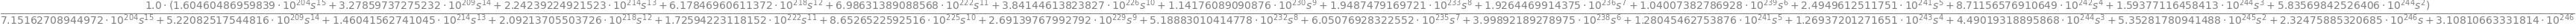

In [89]:
H = U[v2]/U[v1]
H

The SciPy function `bode` is used to calculate the magnitude and phase of the transfer function.

In [90]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to NumPy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)

x = np.logspace(1, 5, 2000, endpoint=False)*2*np.pi
w, mag, phase = signal.bode((a, b), w=x) # returns: rad/s, mag in dB, phase in deg

Read the frequency response data from LTSpice so the LTSpice and Python results plots can be overlaid for comparison.

In [91]:
fn = 'Klon-Centaur_v2_freq_resp.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
H_v2 = np.zeros(len(LTSpice_data)).astype(complex)

# convert the csv data to complex numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    H_v2[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j

Plot the results using `np.unwrap(2 * phase) / 2)` to keep the phase plots the same.

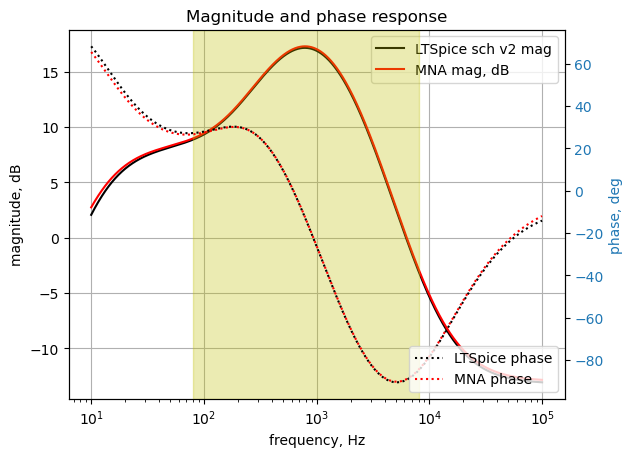

In [92]:
#| label: fig-ltspice-mna-freq-plot
#| echo: true
#| fig-cap: LTSpice and MNA data magnitude and phase response plotted for comparison

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], 20*np.log10(np.abs(H_v2)[0:-1]),'-k',label='LTSpice sch v2 mag')    # LTSpice magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-r',label='MNA mag, dB')    # MNA magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()
plt.legend(loc='upper right')

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.unwrap(2*np.angle(H_v2)[0:-1]/2) *180/np.pi,':',color='k',label='LTSpice phase')  # LTSpice phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='r',label='MNA phase')  # MNA phase plot
plt.legend(loc='lower right')

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

# highlight the guitar audio band, 80 to 8kHz
plt.axvspan(80, 8e3, color='y', alpha=0.3)

plt.title('Magnitude and phase response')
plt.show()

As shown above, there is a slight difference between the MNA results and the LTSpice simulation, but generally there is good agreement. The LTSpice simulation is using device models for the diodes and Op Amps which accounts for the slight differences. 

The poles and zeros of the transfer function can easily be obtained with the following code:

In [93]:
sys_tf = signal.TransferFunction(a,b)

sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

The poles and zeros of the voltage transfer function are plotted on the complex frequency plane.

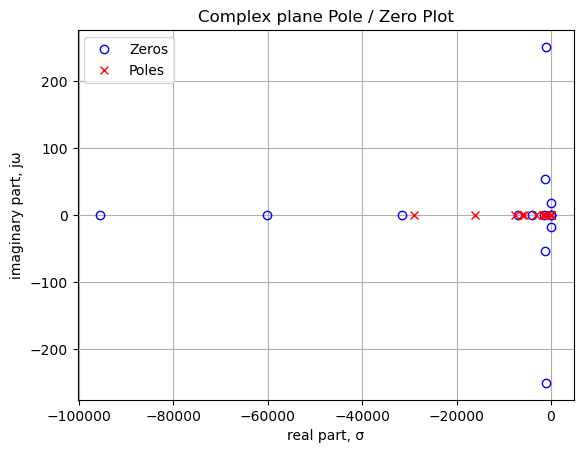

In [94]:
plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Complex plane Pole / Zero Plot')
plt.xlabel('real part, \u03C3')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

Poles and zeros of the transfer function plotted on the complex plane and the units are in radian frequency. These values are printed in the following table.

In [95]:
table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:,.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:,.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s       Poles, rad/s
-----------------  --------------
-95,456.35+0.00j   -29,089.84
-60,141.16+0.00j   -15,995.02
-31,576.17+0.00j   -7,530.71
-7,000.27+0.00j    -6,076.07
-4,086.01+0.00j    -5,671.58
-1,544.35+0.00j    -3,111.00
-1,226.10+53.30j   -1,758.48
-1,226.10-53.30j   -1,455.33
-1,015.01+250.67j  -1,132.02
-1,015.01-250.67j  -1,047.53
-16.52+17.66j      -75.51
-16.52-17.66j      -41.49
-4.72+0.00j        -9.90
0.00+0.00j         -4.97
0.00+0.00j         -2.47


#### Square Wave Response
The SciPy function `lsim` was used to calculate the time domain response to a 10 Hz square wave. The input amplitude is scaled and level shifted to produce a 0 to 50 mV signal which keeps the levels at node 16 below the diode conduction level. 

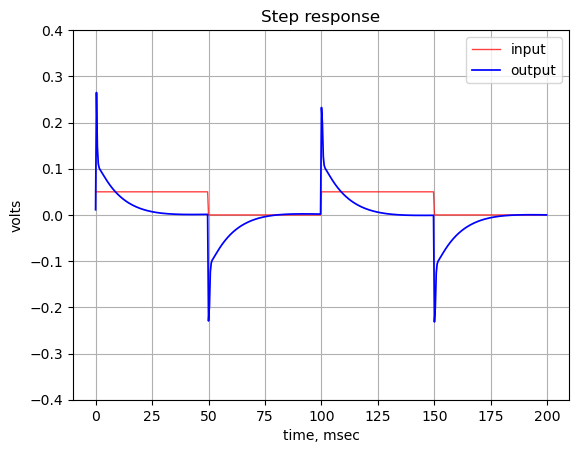

In [96]:
t = np.linspace(0, 0.2, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*10*t, duty=0.5)/40+1/40

t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step*1e3, sqr_signal, 'r', alpha=0.75, linewidth=1, label='input')
plt.plot(t_step*1e3, y_step,'b', linewidth=1.25, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()
plt.ylim((-.4,.4))
plt.legend(loc='best')
# show plot
plt.show()

The plot above shows the input square wave in red and the out signal in blue. The signal path is AC coupled as indicated by the lack of DC response in the plot. The decay time is a bit over 25 ms. 

At the leading edge of the square wave input, there is about a 250 mV spike, which suggests a large AC gain in the circuit because the abrupt change in the input signal at the leading edge of steps of the square wave produces substantial harmonic components within the pass band of the pedal's frequency response.   

The square wave simulation data from LTSpice was loaded in the JupyterLab notebook so that the data could be overlaid along with the NMA solution.

In [97]:
fn = 'Klon-Centaur_v2_square_wave.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

# initialize some empty arrays
time = np.zeros(len(LTSpice_data))
voltage1 = np.zeros(len(LTSpice_data))
voltage2 = np.zeros(len(LTSpice_data))

# convert the csv data to complex numbers and store in the array
for i in range(len(LTSpice_data)):
    time[i] = LTSpice_data[i][0]
    voltage1[i] = LTSpice_data[i][1]
    voltage2[i] = LTSpice_data[i][2]

The code below generates the plots for the LTSpice and Python MNA data.

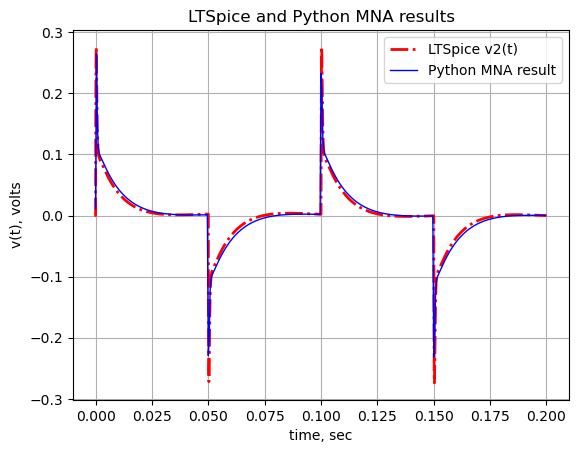

In [98]:
plt.title('LTSpice and Python MNA results')

#plt.plot(time, voltage1, 'g', alpha = 1.0, linewidth=1, label='LTSpice v1(t)')
plt.plot(time, voltage2, '-.r', alpha = 1.0, linewidth=2, label='LTSpice v2(t)')

#plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', alpha = 1.0, linewidth = 1.0, label='Python MNA result')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

As shown above, there is close agreement between the two solutions in both the frequency and time domain for input signal levels and gain settings that do not produce node voltages at node 16 with levels that would drive the diodes into conduction.

## Summary for part 2
The semiconductor parts used in the pedal were described as well as the SPICE device models used in the LTSpice simulations. The MNA method can not easily handle the non-linear operation resulting from saturated Op Amp outputs or forwarded biased diodes. LTSpice was used to examine the operating point where the Op Amps would be driven into saturation. 

From the analysis it appears that output of $U_{1A}$ could be clipping the signal at some combinations of input level and gain. Python was used to display the results of LTSpice transient analysis and the harmonic content of the distorted signal was plotted. The operation of the pedal with actual music signals as inputs was simulated. This illustrates how MNA can be used in conjunction with LTSpice to do circuit analysis and generate reports. 

Finally analysis results obtained from LTSpice were compared to the Python MNA results. The magnitude, phase and time domain plots superimpose giving us confidence that the Python analysis results are correct. 